In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sc
np.set_printoptions(suppress=True)

In [72]:
def read_file(filename):
    names, errors, shape, loss = [], [], [], []
    with open(filename, 'r') as file:
        for line in file:
            # Split the line into its components using whitespace as the delimiter
            parts = line.strip().split()
            # Extract the "name", "val1", and "val2" from the parts list
            names.append(parts[0])
            errors.append(float(parts[1]))
            shape.append(float(parts[2]))
            if len(parts) == 4:
                loss.append(float(parts[3]))
    return names, errors, shape, loss

def checkNumVar(codeNum, varNum):
    # varNum: 1-6, codeNum: 0-63
    for i in range(varNum):
        out = int(codeNum%2)
        codeNum = int(codeNum/2)
    return out


def getCodeNumsWithVars(vars, numTotVars=7):
    codeNums = []
    for i in range(2**numTotVars):
        lst = []
        for v in vars:
            lst.append(checkNumVar(i, v))
        if (all(num == 1 for num in lst)):
            codeNums.append(i)
    return codeNums


def getCodeNumsNumVars(numVars, numTotVars=7):
    codeNums = []
    for i in range(2**numTotVars):
        lst = []
        for v in range(1, numTotVars+1):
            lst.append(checkNumVar(i, v))
        if (sum(lst) == numVars):
            codeNums.append(i)
    return codeNums

def getVarsFromCode(code):
    vars = []
    count = 0
    while code > 0:
        count += 1
        if(code%2):
            vars.append(count)
        code = int(code/2)
    return vars

def colorScale(hexColor1, hexColor2, numColors=2):
    out = []
    hexColor1, hexColor2 = hexColor1.lstrip('#'), hexColor2.lstrip('#')
    r1, g1, b1 = int(hexColor1[0:2], 16), int(hexColor1[2:4], 16), int(hexColor1[4:6], 16)
    r2, g2, b2 = int(hexColor2[0:2], 16), int(hexColor2[2:4], 16), int(hexColor2[4:6], 16)
    slope_r, slope_g, slope_b = (r2-r1)/(numColors-1), (g2-g1)/(numColors-1), (b2-b1)/(numColors-1)
    for i in range(numColors):
        out.append("#" + "{:02x}".format(int(r1+i*slope_r)).upper() + "{:02x}".format(int(g1+i*slope_g)).upper() + "{:02x}".format(int(b1+i*slope_b)).upper())
    return out

def getInterval(errVal, spacing=0.2):
    for v in np.arange(3.5, 5.001, spacing):
        if v >= errVal and v - spacing < errVal:
            return (round(v-spacing, 3), round(v, 3))
        
def getCodeFromBinary(s):
    for i in range(len(s)):
        if s[i].isalpha():
            return getCodeFromBinary(s[:i] + '0' + s[i+1:]) + getCodeFromBinary(s[:i] + '1' + s[i+1:])
    return [int(s, 2)]

def checkBadCombinations(names, losses, nvars = [2], lossThresh = 32):
    badNames = []
    for n, l in zip(names, losses):
        if len(n.split("_")) - 3 in nvars and l > lossThresh:
            badNames.append("_".join(n.split("_")[3:]))
    return sorted(list(set(badNames)))

def plotOption(df, option, xmin, xmax, step_size, nbins=50):
    # NTrees---------------------------------------------------------------------------------------['Error_v01', 'Error_v14', 'Error_v014', 'Error_v019', 'Error_v149', 'Error_v0149', 'Loss_v01', 'Loss_v14', 'Loss_v014', 'Loss_v019', 'Loss_v149', 'Loss_v0149']
    #for discrete RndmTrees UseBaggedBoost PruneMethod
    if option not in ["RndmTrees", "UseBaggedBoost", "PruneMethod"]:
        intervals_option = np.linspace(df[option].min(), df[option].max(), 26)
        df['Bin'+option] = pd.cut(df[option], bins=intervals_option, labels = (intervals_option[:-1]+intervals_option[1:])/2, include_lowest=True)
    plt.figure(figsize=(16, 12))

    plt.subplot(2, 2, 1)
    plt.scatter(df[option], df["Error_v01"], s=10, color="#33bb55")
    plt.scatter(df[option], df["Error_v14"], s=10, color="#33bb55")
    plt.scatter(df[option], df["Error_v014"], s=10, color="#33bb55")
    plt.scatter(df[option], df["Error_v019"], s=10, color="#33bb55")
    plt.scatter(df[option], df["Error_v149"], s=10, color="#33bb55")
    plt.scatter(df[option], df["Error_v0149"], s=10, color="#33bb55")
    if option not in ["RndmTrees", "UseBaggedBoost", "PruneMethod"]:
        means = np.mean(df.groupby('Bin'+option)[['Error_v01', 'Error_v14', 'Error_v014', 'Error_v019', 'Error_v149', 'Error_v0149']].mean().to_numpy(), axis=1)
        devs = np.sqrt(np.mean(df.groupby('Bin'+option)[['Error_v01', 'Error_v14', 'Error_v014', 'Error_v019', 'Error_v149', 'Error_v0149']].std().to_numpy()**2, axis=1))
        plt.errorbar(list(df.groupby('Bin'+option).groups.keys()), means, devs, fmt='-o', color="#3333ff", capsize=8)
    else:
        means = np.mean(df.groupby(option)[['Error_v01', 'Error_v14', 'Error_v014', 'Error_v019', 'Error_v149', 'Error_v0149']].mean().to_numpy(), axis=1)
        devs = np.sqrt(np.mean(df.groupby(option)[['Error_v01', 'Error_v14', 'Error_v014', 'Error_v019', 'Error_v149', 'Error_v0149']].std().to_numpy()**2, axis=1))
        plt.errorbar(list(df.groupby(option).groups.keys()), means, devs, fmt='o', color="#3333ff", capsize=8)
    plt.title("Error vs {}".format(option))
    #plt.yscale('log')
    plt.xticks(np.arange(xmin, xmax + step_size, step_size))
    plt.xticks(rotation=90)
    plt.grid()

    plt.subplot(2, 2, 2)
    plt.scatter(df[option], df["Loss_v01"], s=10, color="#ff3333")
    plt.scatter(df[option], df["Loss_v14"], s=10, color="#ff3333")
    plt.scatter(df[option], df["Loss_v014"], s=10, color="#ff3333")
    plt.scatter(df[option], df["Loss_v019"], s=10, color="#ff3333")
    plt.scatter(df[option], df["Loss_v149"], s=10, color="#ff3333")
    plt.scatter(df[option], df["Loss_v0149"], s=10, color="#ff3333")
    if option not in ["RndmTrees", "UseBaggedBoost", "PruneMethod"]:
        means = np.mean(df.groupby('Bin'+option)[['Loss_v01', 'Loss_v14', 'Loss_v014', 'Loss_v019', 'Loss_v149', 'Loss_v0149']].mean().to_numpy(), axis=1)
        devs = np.sqrt(np.mean(df.groupby('Bin'+option)[['Loss_v01', 'Loss_v14', 'Loss_v014', 'Loss_v019', 'Loss_v149', 'Loss_v0149']].std().to_numpy()**2, axis=1))
        plt.errorbar(list(df.groupby('Bin'+option).groups.keys()), means, devs, fmt='-o', color="#3333ff", capsize=8)
    else:
        means = np.mean(df.groupby(option)[['Loss_v01', 'Loss_v14', 'Loss_v014', 'Loss_v019', 'Loss_v149', 'Loss_v0149']].mean().to_numpy(), axis=1)
        devs = np.sqrt(np.mean(df.groupby(option)[['Loss_v01', 'Loss_v14', 'Loss_v014', 'Loss_v019', 'Loss_v149', 'Loss_v0149']].std().to_numpy()**2, axis=1))
        plt.errorbar(list(df.groupby(option).groups.keys()), means, devs, fmt='o', color="#3333ff", capsize=8)
    plt.title("Loss vs {}".format(option))
    #plt.yscale('log')
    plt.grid()

    plt.subplot(2, 2, 3)
    plt.hist(df[option], bins=nbins)
    plt.title(option)
    plt.xticks(np.arange(xmin, xmax + step_size, step_size))
    plt.xticks(rotation=90)
    plt.grid()

    plt.tight_layout()
    plt.show()


In [73]:
print(colorScale("#00ffff", "#000000", 4))

['#00FFFF', '#00AAAA', '#005555', '#000000']


In [93]:
def plotEval(names, errors, shapes, losses, var=[], intervalLoss=(0,0), intervalError=(0,0), fullNames=[]):
    colorsVars = {0: "#FFFF00", 1: "#AAAA00", 2: "#FF0000", 3: "#AA0000", 4: "#00FF00", 5: "#00AA00", 6: "#0000FF", 7: "#0000AA", 8: "#00FFFF", 9: "#00AAAA"}
    plt.figure(figsize=(12, 8))
    selected = []

    plt.scatter(errors, losses, color="#CCCC00", label='placeholder', s=20, alpha=1.0, edgecolor="none")
    for n, e, s, l in zip(names, errors, shapes, losses):
        if n == "RECO":
            plt.scatter(e, l, color="#33bb88", label='Reco', s=100, alpha=1.0, edgecolor="#000000")
        elif n[-4:] == "opt0"[-4:]:
            plt.scatter(e, l, color="#ff0000", s=30, alpha=1.0, edgecolor="#000000")
        elif int(n.split("_")[-1].replace("opt", "")) > 2002:
            plt.scatter(e, l, color="#0000ff", s=30, alpha=1.0, edgecolor="#000000")
        if (l > intervalLoss[0] and l < intervalLoss[1] and e > intervalError[0] and e < intervalError[1] and estimation(e, *p)  - 3 > l) or n in fullNames:
                print(n, e, l)
                #plt.annotate(n, (e, l), textcoords="offset points", xytext=(5,-2), ha='left')
                plt.scatter(e, l, color="#aaaaff", s=70, alpha=1.0, edgecolor="#000000")
                selected.append(int(n.split("_")[-1].replace("opt", "")))
    
    '''
    for n, e, s, l in zip(names[1:], errorsDifferentVars[1:], shapesDifferentVars[1:], lossesDifferentVars[1:]):
        if len(n) > 0:
            numVars = len(n[0].split("_")) - 3
            if numVars > 0:
                plt.scatter(e, l, color=colorsVars[numVars], s=30, label="{} vars".format(numVars), alpha=1.0, edgecolor="#222222")

    avgErr, avgLoss, count = 0, 0, 0
    for n, e, s, l in zip(names, errorsDifferentVars, shapesDifferentVars, lossesDifferentVars):
        for i in range(len(n)):
            if any(item in n[i].split("_")[1:] for item in var):
                if e[i] < 5 and l[i] < 29:
                    print(n[i], e[i], l[i])
                    plt.scatter(e[i], l[i], color="#cccc00", s=80, alpha=1.0, edgecolor="#000000")
                avgErr += e[i]
                avgLoss += l[i]
                count += 1
            if (l[i] > intervalLoss[0] and l[i] < intervalLoss[1] and e[i] > intervalError[0] and e[i] < intervalError[1]) or n[i] in fullNames:
                print(n[i], "df", getVarsFromCode(int(n[i].split("_")[1].replace("df", ""))), "\tdl", getVarsFromCode(int(n[i].split("_")[2].replace("dl", ""))), e[i], l[i])
                #plt.annotate(n[i], (e[i], l[i]), textcoords="offset points", xytext=(5,-2), ha='left')
                plt.scatter(e[i], l[i], color="#aaaaff", s=70, alpha=1.0, edgecolor="#000000")'''


    


    '''

    mine_l, mine_e, mine_s = 0, 10, 0
    minl_l, minl_e, minl_s = 0, 0, 200

    for label, e, s in zip(names_filt, errors_filt, loss_filt):
        if s < 24 and e < 4.5:
            if e < mine_e:
                mine_l, mine_e, mine_s = label, e, s
            if s < minl_s:
                minl_l, minl_e, minl_s = label, e, s
    print(mine_l, mine_e, mine_s)
    plt.annotate(mine_l, (mine_e, mine_s), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
    plt.scatter(mine_e, mine_s, color="#ffffff", s=60, alpha=1.0, edgecolor="#000000")
    print(minl_l, minl_e, minl_s)
    plt.annotate(minl_l, (minl_e, minl_s), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
    plt.scatter(minl_e, minl_s, color="#ffffff", s=60, alpha=1.0, edgecolor="#000000")

    mine_l, mine_e, mine_s = 0, 10, 0
    minl_l, minl_e, minl_s = 0, 0, 200

    for label, e, s in zip(names_filt, errors_filt, loss_filt):
        if s < 22 and e < 4.67:
            if e < mine_e:
                mine_l, mine_e, mine_s = label, e, s
            if s < minl_s:
                minl_l, minl_e, minl_s = label, e, s
    print(mine_l, mine_e, mine_s)
    plt.annotate(mine_l, (mine_e, mine_s), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
    plt.scatter(mine_e, mine_s, color="#ffffff", s=60, alpha=1.0, edgecolor="#000000")
    print(minl_l, minl_e, minl_s)
    plt.annotate(minl_l, (minl_e, minl_s), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
    plt.scatter(minl_e, minl_s, color="#ffffff", s=60, alpha=1.0, edgecolor="#000000
    '''
    '''
    namesTotal, errorsTotal, lossesTotal = [], [], []

    for n, e, l in zip(names, errorsDifferentVars, lossesDifferentVars):
        namesTotal += n
        errorsTotal += e
        lossesTotal += l

    classified = {}
    for n, e, l in zip(namesTotal, errorsTotal, lossesTotal):
        if e > 3.5 and e < 5:
            inter = getInterval(e, spacing=0.02)
            if inter not in classified:
                classified[inter] = [[n, float(e), float(l)]]
            else:
                classified[inter] = classified[inter] + [[n, float(e), float(l)]]

    for key, value in classified.items():
        models = np.array(classified[key])
        losses = np.asarray(models[:, 2], dtype=float)

        midpoint50 = (np.max(losses) + np.min(losses)) / 2
        midpoint25 = np.min(losses) + (np.max(losses) - np.min(losses))*0.25
        midpoint75 = np.min(losses) + (np.max(losses) - np.min(losses))*0.75
        midpoint20 = np.min(losses) + (np.max(losses) - np.min(losses))*0.20
        midpoint40 = np.min(losses) + (np.max(losses) - np.min(losses))*0.40
        midpoint60 = np.min(losses) + (np.max(losses) - np.min(losses))*0.60
        midpoint80 = np.min(losses) + (np.max(losses) - np.min(losses))*0.80


        newKeyVals = np.asarray([models[np.where(losses == np.percentile(losses, 0, method="nearest"))[0][0]],
                                models[np.abs(losses - midpoint20).argmin()],
                                models[np.abs(losses - midpoint40).argmin()],
                                models[np.abs(losses - midpoint60).argmin()],
                                models[np.abs(losses - midpoint80).argmin()],
                                models[np.where(losses == np.percentile(losses, 100, method="nearest"))[0][0]]])
        newKeyVals = np.asarray([models[np.where(losses == np.percentile(losses, 0, method="nearest"))[0][0]]])
        
        classified[key] = newKeyVals

    newModels = []

    for key, value in classified.items():
        for e in value:
            plt.scatter(float(e[1]), float(e[2]), color="#000000", s=160, alpha=1.0, edgecolor="#000000")
            newModels.append(e[0])
    print(len(newModels))'''
    
    '''
    newModels = []
    for n, e, s in zip(names_filt, errors_filt, loss_filt):
        if s < estimation(e, *p):
            newModels.append(n)
    '''
    

    x = np.linspace(2.75, 6.0)
    plt.plot(x, estimation(x, *p), color="#2244ff", linewidth=2)

    plt.xlabel('Mean error in pt (predicted - gen) GeV')
    plt.ylabel('Loss')
    plt.title('Mean PT error pt vs Loss')
    xmin, xmax, xsep = 2.5, 6, 0.5
    #xmin, xmax, xsep = 6.2, 6.35, 0.01
    ymin, ymax, ysep = 5, 60, 5
    #ymin, ymax, ysep = 172, 180, 1
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin, ymax+0.001, ysep))
    plt.xticks(np.arange(xmin, xmax+0.001, xsep))
    plt.grid()
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    return sorted(list(set(selected)))

    #print(var, avgErr/count, avgLoss/count, count)

11690 11690 11690 11690
[ 9.12402843 71.68779555  0.31290356]
[0.62563901 1.72428267 0.01090454]
BDTG_df15_dl3684_v0_v1_opt0 3.9362027839044305 20.81964885755457
BDTG_df15_dl3684_v0_v1_opt144 4.014018889860682 19.455583793345994
BDTG_df15_dl3684_v0_v1_opt316 3.9471228745686293 19.44329945449841
BDTG_df15_dl3684_v0_v1_opt520 3.8527563807878074 20.807707717507704
BDTG_df15_dl3684_v0_v1_opt587 3.9124259471765543 18.90235893175838
BDTG_df15_dl3684_v0_v1_opt594 3.8373012066301033 20.575465860217548
BDTG_df15_dl3684_v0_v1_opt739 3.90872099577679 20.64915049982455
BDTG_df15_dl3684_v0_v1_opt808 3.9890939909547583 19.88571444808587
BDTG_df15_dl3684_v0_v1_opt819 3.8792170148192753 20.748771525976544
BDTG_df15_dl3684_v0_v1_opt890 3.9236910444049586 20.53038285375652
BDTG_df15_dl3684_v0_v1_opt968 4.000580199195159 19.70581672372067
BDTG_df15_dl3684_v0_v1_v4_opt144 4.001320505158038 19.398350626895088
BDTG_df15_dl3684_v0_v1_v4_opt310 3.9019078016004185 19.540914539663973
BDTG_df15_dl3684_v0_v1_v4_o

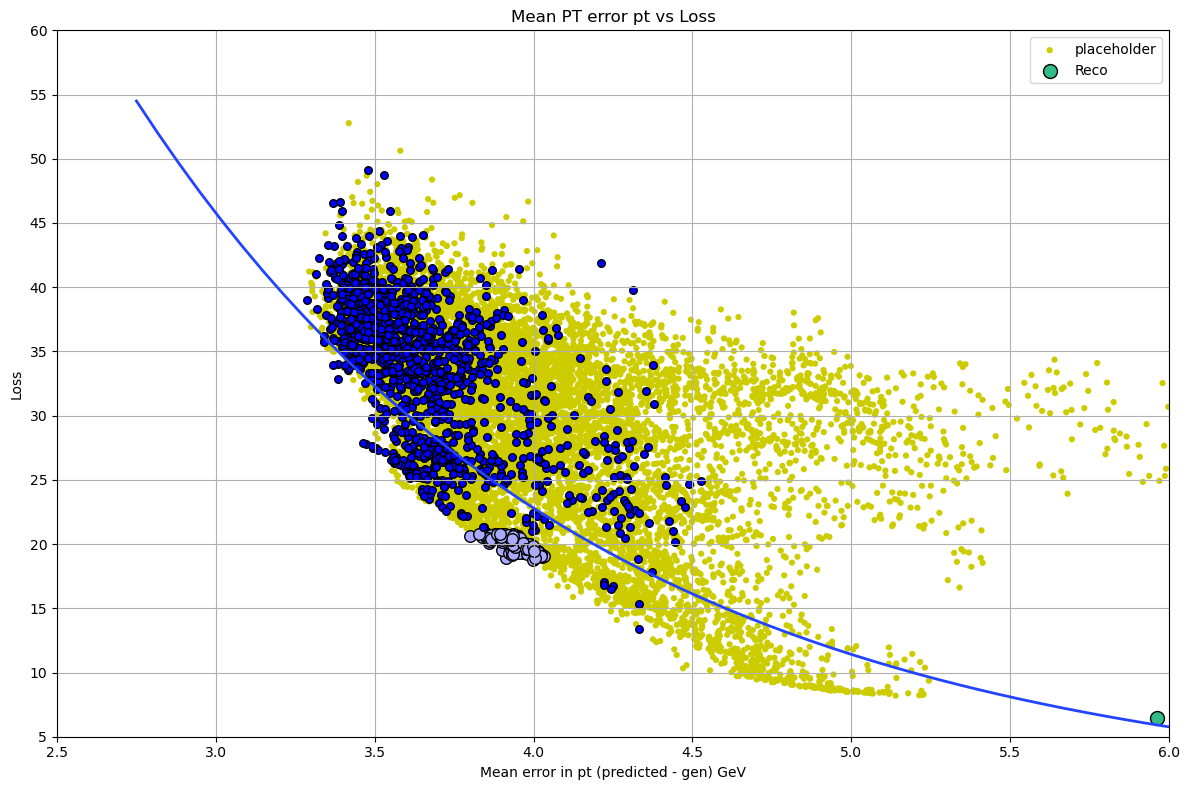

In [94]:
names, errors, shapes, losses = read_file("eval_all_phi_opts.out")
names_filt, errors_filt, shapes_filt, losses_filt = read_file("eval_all_phi_opts.out")
print(len(names), len(errors), len(shapes), len(losses))

def estimation(x, a, b, c):
    return a + b*np.exp(-c*x)

p,q = sc.curve_fit(estimation, errors, losses, p0=[1, 200, 0.7], maxfev=10000)
print(p)
print(np.sqrt(np.diag(q)))
p = [  0.21340494, 373.62622177,   0.70145433]

#Threshold of a valid model: loss < 20
#["BDTG_df15_dl3684_v0_v1_opt0", "BDTG_df15_dl3684_v1_v4_opt0", "BDTG_df15_dl3684_v0_v1_v4_opt0", "BDTG_df15_dl3684_v0_v1_v9_opt0", "BDTG_df15_dl3684_v1_v4_v9_opt0", "BDTG_df15_dl3684_v0_v1_v4_v9_opt0"]
#intervalLoss=(15, 20.8197), intervalError=(3.5, 4.03435)
newModels = plotEval(names, errors, shapes, losses, var=[], intervalLoss=(15, 20.82), intervalError=(3.5, 4.035), fullNames=[])

In [90]:
print(len(newModels))
print(newModels)

38
[0, 13, 88, 144, 159, 160, 310, 316, 380, 520, 587, 594, 607, 659, 739, 808, 819, 890, 968, 1019, 1043, 1110, 1146, 1198, 1206, 1218, 1236, 1247, 1314, 1334, 1395, 1397, 1427, 1466, 1602, 1687, 1713, 1723]


,Id,VarTsf,NTrees,BoostType,Shrinkage,MaxDepth,SeparationType,nCuts,RndmTrees,UseNvars,...,Error_v014,Error_v019,Error_v149,Error_v0149,Loss_v01,Loss_v14,Loss_v014,Loss_v019,Loss_v149,Loss_v0149
0,0,,1000,Grad,0.20000,5,RegressionVariance,90,T,67,...,3.953916,3.942602,4.034347,3.955025,20.819649,19.031700,20.782679,20.724311,19.033140,20.692992
1,1,"D,P",1981,Grad,0.83088,6,RegressionVariance,98,F,52,...,5.929491,6.107214,6.134376,6.140391,26.119666,27.656506,29.337442,25.690084,25.811674,27.754373
2,2,"N,D",588,Grad,0.65251,4,RegressionVariance,8,F,12,...,4.241897,4.300140,4.317204,4.281865,20.437652,20.146472,20.647610,19.704832,19.531750,19.984480
3,3,"G,D,P,G",776,Grad,0.38773,7,RegressionVariance,15,F,84,...,4.111991,4.168919,4.145046,4.170326,30.618658,29.888505,29.398207,30.010600,28.222803,28.484072
4,4,"P,D,N",549,Grad,0.17749,7,RegressionVariance,62,F,94,...,3.781988,4.100126,4.061576,3.988523,30.295753,23.474014,28.873749,22.156984,19.828075,27.614318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3298,3298,"G,N,G,P",2370,Grad,0.45432,8,RegressionVariance,35,F,58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3299,3299,"G,D,G,D",4947,Grad,0.12281,10,RegressionVariance,83,T,92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3300,3300,"N,G",1828,Grad,0.30091,6,RegressionVariance,32,T,77,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3301,3301,,3644,Grad,0.25545,10,RegressionVariance,87,F,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3303
3303
1866
38


,Id,VarTsf,NTrees,BoostType,Shrinkage,MaxDepth,SeparationType,nCuts,RndmTrees,UseNvars,...,Error_v014,Error_v019,Error_v149,Error_v0149,Loss_v01,Loss_v14,Loss_v014,Loss_v019,Loss_v149,Loss_v0149
0,0,,1000,Grad,0.20000,5,RegressionVariance,90,T,67,...,3.953916,3.942602,4.034347,3.955025,20.819649,19.031700,20.782679,20.724311,19.033140,20.692992
13,13,,2996,Grad,0.07243,8,RegressionVariance,28,T,5,...,3.833496,3.839931,3.934453,3.841105,21.714954,20.381714,21.475374,21.276597,20.002671,21.010503
88,88,,2750,Grad,0.07923,10,RegressionVariance,62,T,5,...,3.779260,3.783447,3.867018,3.802021,21.864930,20.914568,21.568255,21.537334,20.364250,21.272949
144,144,,954,Grad,0.15806,6,RegressionVariance,68,F,9,...,4.001321,4.012102,4.084410,4.005582,19.455584,17.995956,19.398351,19.345669,18.204301,19.286429
159,159,,2499,Grad,0.04674,10,RegressionVariance,85,F,76,...,3.788769,3.795765,3.862260,3.806829,21.491054,20.447671,21.235705,21.246298,20.224670,21.089710
160,160,"P,G",1794,Grad,0.04178,7,RegressionVariance,44,T,65,...,3.702815,4.093446,4.042534,3.967179,30.674183,28.233672,28.407297,18.869697,18.662920,19.956449
310,310,"G,N,D",1177,Grad,0.09383,4,RegressionVariance,87,T,86,...,3.901908,3.984945,3.941636,3.922320,20.869741,19.950827,19.540915,19.867219,20.266613,19.282327
316,316,G,2916,Grad,0.04503,6,RegressionVariance,30,F,53,...,3.962604,3.953081,4.043065,3.965863,19.443299,18.341826,19.567569,19.319004,18.225105,19.334937
380,380,"N,G",1379,Grad,0.12591,6,RegressionVariance,12,T,56,...,3.870446,3.878730,3.970357,3.887399,21.714424,20.064263,21.622225,21.612021,19.893185,21.278230
520,520,"G,N,G",2685,Grad,0.04507,8,RegressionVariance,51,F,31,...,3.852172,3.854982,3.935296,3.859419,20.807708,19.934869,20.807896,20.707568,19.693310,20.565819


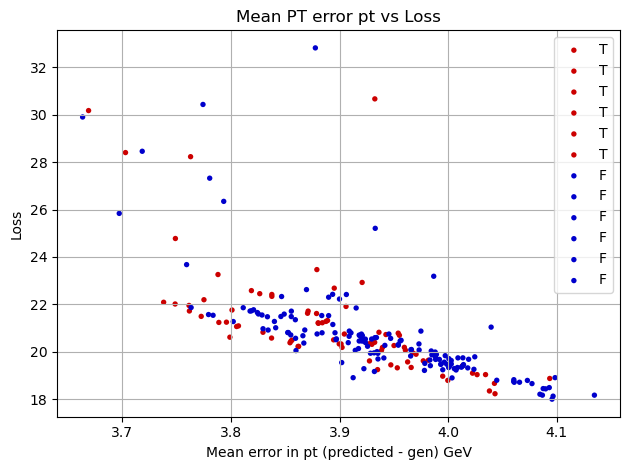

In [86]:
#Read model properties from file, and create pandas dataframe to be able to select different model criteria to study the behaviour
#two plots per option: vs error / vs loss

def getModelOptions(fileName="/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/TMVA_regression/optionModels.out"):
    column_names = ['Id', 'VarTsf', 'NTrees', 'BoostType', 'Shrinkage', 'MaxDepth', 'SeparationType', 'nCuts', 'RndmTrees',
                    'UseNvars', 'UseBaggedBoost', 'BaggedSampleFraction', 'PruneMethod', 'PruneStrength', 'PruningValFraction']
    column_data_types = {'Id': int, 'VarTsf': str, 'NTrees': int, 'BoostType': str, 'Shrinkage': float, 'MaxDepth': int, 'SeparationType': str, 'nCuts': int, 'RndmTrees': str,
                    'UseNvars': int, 'UseBaggedBoost': str, 'BaggedSampleFraction': float, 'PruneMethod': str, 'PruneStrength': int, 'PruningValFraction': float}
    
    df = pd.read_csv(fileName, sep='$', names=column_names, dtype=column_data_types)
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    return df


def addErrorLosses(dfOptions, fileName="eval_all_phi_opts.out"):
    new_column_names = ['Error_v01', 'Error_v14', 'Error_v014', 'Error_v019', 'Error_v149', 'Error_v0149',
                         'Loss_v01', 'Loss_v14', 'Loss_v014', 'Loss_v019', 'Loss_v149', 'Loss_v0149']
    
    for column in new_column_names:
        dfOptions[column] = np.nan
    
    with open(fileName, 'r') as file:
        for line in file:
            parts = line.strip().split()
            #print(parts)
            if parts[0] != "RECO":
                identifier = int(parts[0].split("_")[-1].replace("opt", ""))
                variables = "v" + "".join([v.replace("v", "") for v in parts[0].split("_")[3:-1]])
                error = float(parts[1])
                loss = float(parts[3])

                dfOptions.loc[dfOptions['Id'] == identifier, 'Error_' + variables] = error
                dfOptions.loc[dfOptions['Id'] == identifier, 'Loss_' + variables] = loss
                #print(identifier, variables, error, loss)
    return dfOptions

pddf = getModelOptions()
pddf = addErrorLosses(pddf)
display(pddf)
maxError, maxLoss = 4.03435, 20.8197
maxError=5.1
#pddf = pddf[10 + 0.2134 + 373.626*np.exp(-0.701*pddf["Error_v014"]) < pddf["Loss_v014"]]
#pddf = pddf[(pddf["Error_v01"] < maxError) | (pddf["Error_v14"] < maxError) | (pddf["Error_v014"] < maxError) | (pddf["Error_v019"] < maxError) | (pddf["Error_v149"] < maxError) | (pddf["Error_v0149"] < maxError)]
print(len(pddf))
#pddf = pddf[(pddf["Loss_v01"] < maxLoss) | (pddf["Loss_v14"] < maxLoss) | (pddf["Loss_v014"] < maxLoss) | (pddf["Loss_v019"] < maxLoss) | (pddf["Loss_v149"] < maxLoss) | (pddf["Loss_v0149"] < maxLoss)]
print(len(pddf))
#intervalLoss=(15, 20.8197), intervalError=(3.5, 4.03435)
pddf = pddf[pddf["Error_v014"].notna()]
#pddf = pddf[pddf["UseBaggedBoost"] == "T"]
print(len(pddf))
pddf = pddf[pddf["Id"].isin(newModels)]
print(len(pddf))
display(pddf)

plt.scatter(pddf[pddf["UseBaggedBoost"] == "T"]['Error_v01'], pddf[pddf["UseBaggedBoost"] == "T"]['Loss_v01'], color="#cc0000", label='T', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "T"]['Error_v14'], pddf[pddf["UseBaggedBoost"] == "T"]['Loss_v14'], color="#cc0000", label='T', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "T"]['Error_v014'], pddf[pddf["UseBaggedBoost"] == "T"]['Loss_v014'], color="#cc0000", label='T', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "T"]['Error_v019'], pddf[pddf["UseBaggedBoost"] == "T"]['Loss_v019'], color="#cc0000", label='T', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "T"]['Error_v149'], pddf[pddf["UseBaggedBoost"] == "T"]['Loss_v149'], color="#cc0000", label='T', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "T"]['Error_v0149'], pddf[pddf["UseBaggedBoost"] == "T"]['Loss_v0149'], color="#cc0000", label='T', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "F"]['Error_v01'], pddf[pddf["UseBaggedBoost"] == "F"]['Loss_v01'], color="#0000cc", label='F', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "F"]['Error_v14'], pddf[pddf["UseBaggedBoost"] == "F"]['Loss_v14'], color="#0000cc", label='F', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "F"]['Error_v014'], pddf[pddf["UseBaggedBoost"] == "F"]['Loss_v014'], color="#0000cc", label='F', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "F"]['Error_v019'], pddf[pddf["UseBaggedBoost"] == "F"]['Loss_v019'], color="#0000cc", label='F', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "F"]['Error_v149'], pddf[pddf["UseBaggedBoost"] == "F"]['Loss_v149'], color="#0000cc", label='F', s=15, alpha=1.0, edgecolor="none")
plt.scatter(pddf[pddf["UseBaggedBoost"] == "F"]['Error_v0149'], pddf[pddf["UseBaggedBoost"] == "F"]['Loss_v0149'], color="#0000cc", label='F', s=15, alpha=1.0, edgecolor="none")
plt.xlabel('Mean error in pt (predicted - gen) GeV')
plt.ylabel('Loss')
plt.title('Mean PT error pt vs Loss')
xmin, xmax, xsep = 2.5, 6, 0.5
#xmin, xmax, xsep = 6.2, 6.35, 0.01
ymin, ymax, ysep = 5, 60, 5
#ymin, ymax, ysep = 172, 180, 1
#plt.xlim(xmin, xmax)
#plt.ylim(ymin, ymax)
#plt.yticks(np.arange(ymin, ymax+0.001, ysep))
#plt.xticks(np.arange(xmin, xmax+0.001, xsep))
plt.grid()
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


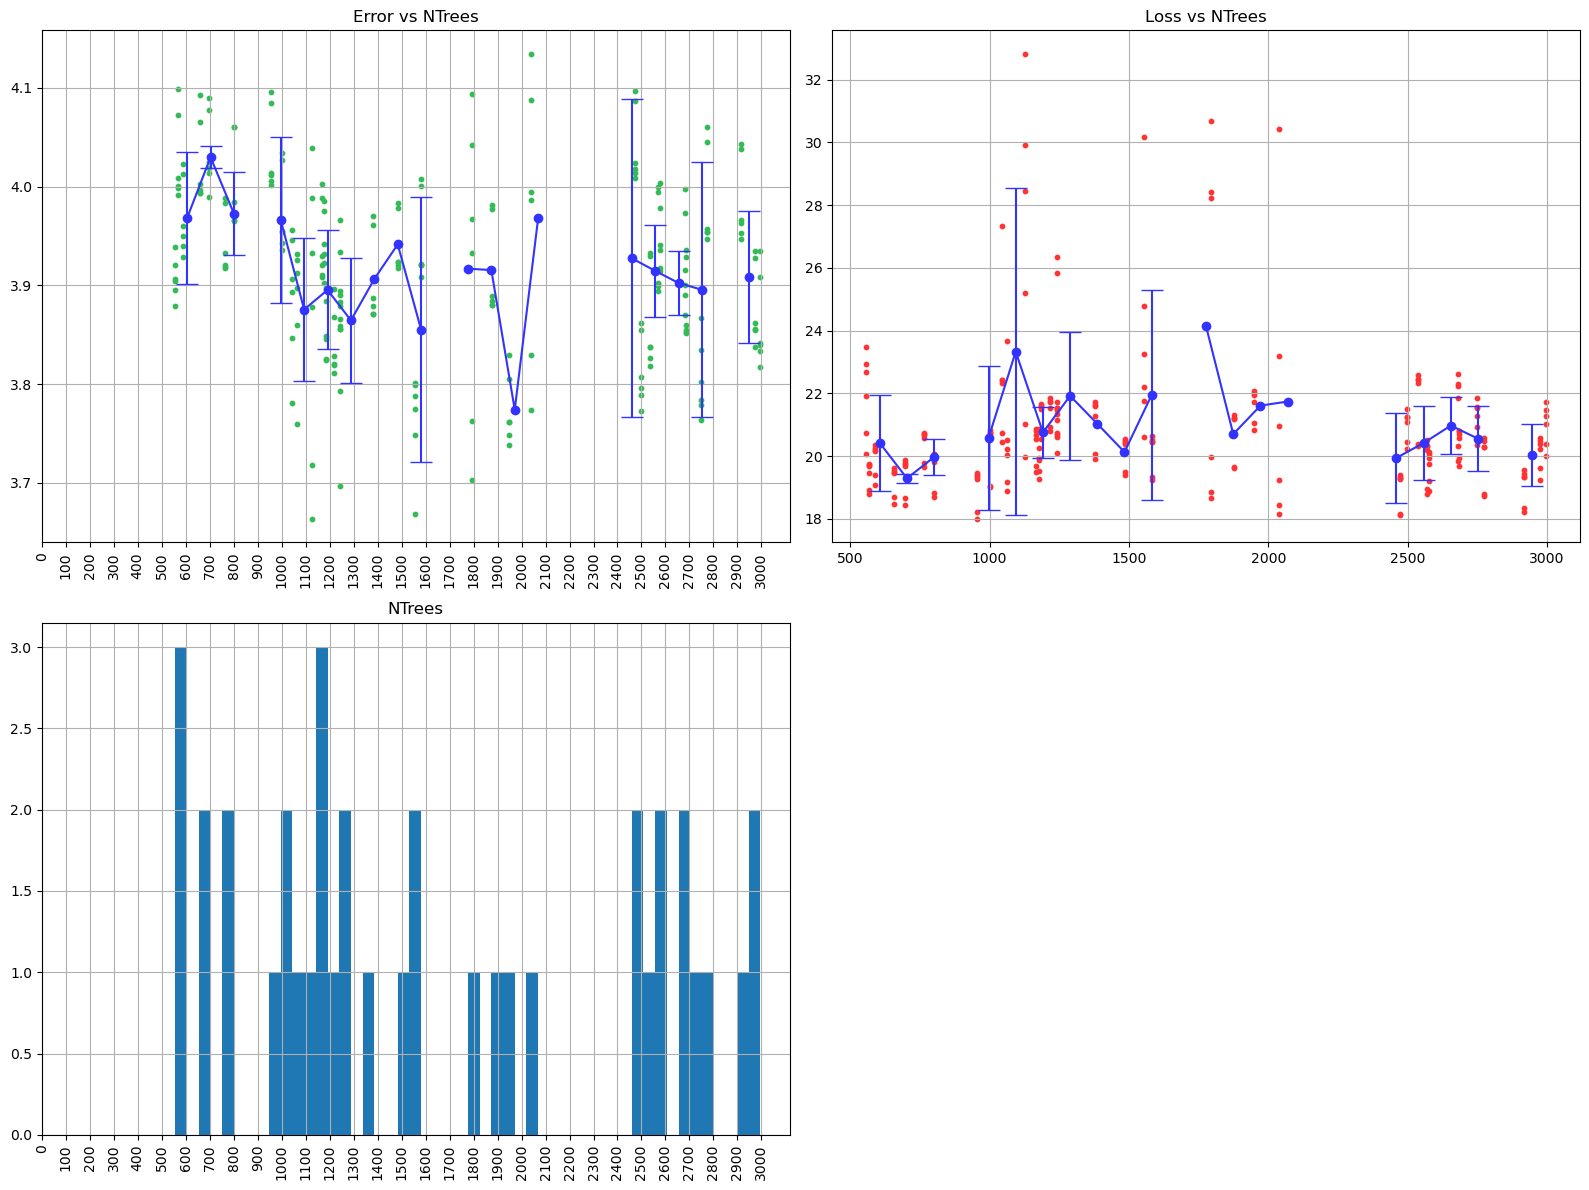

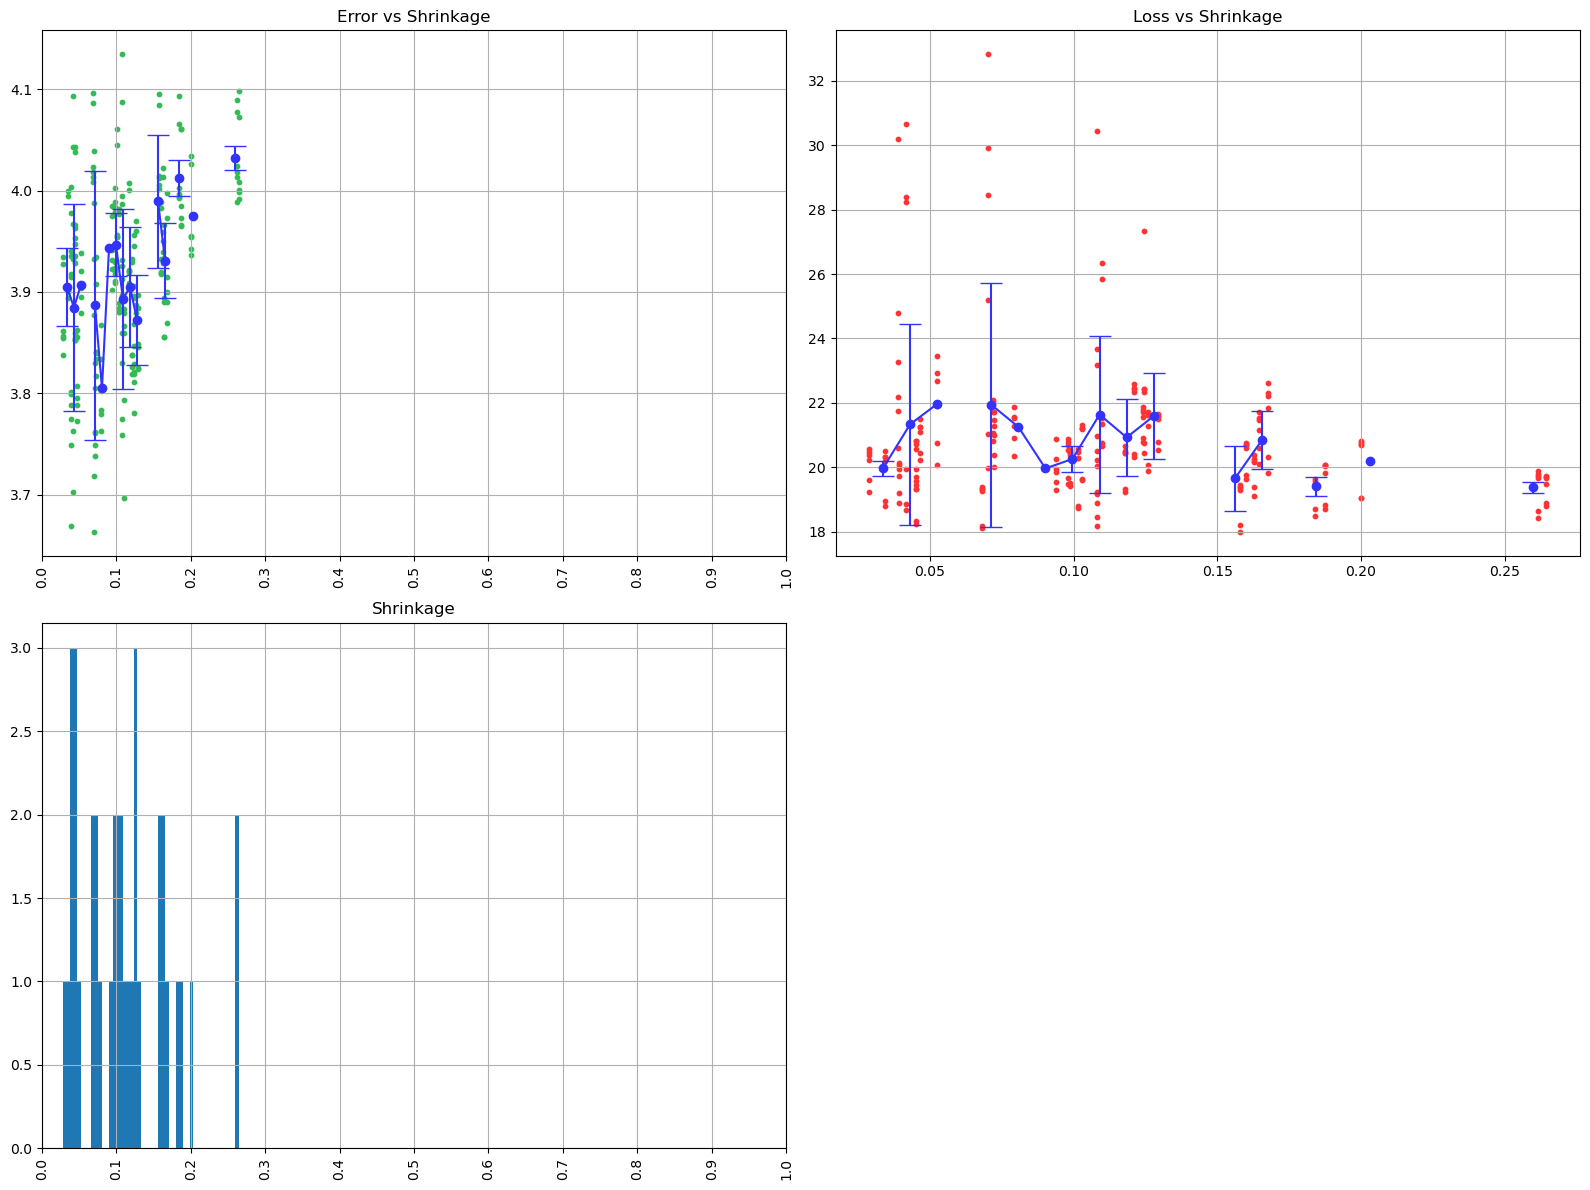

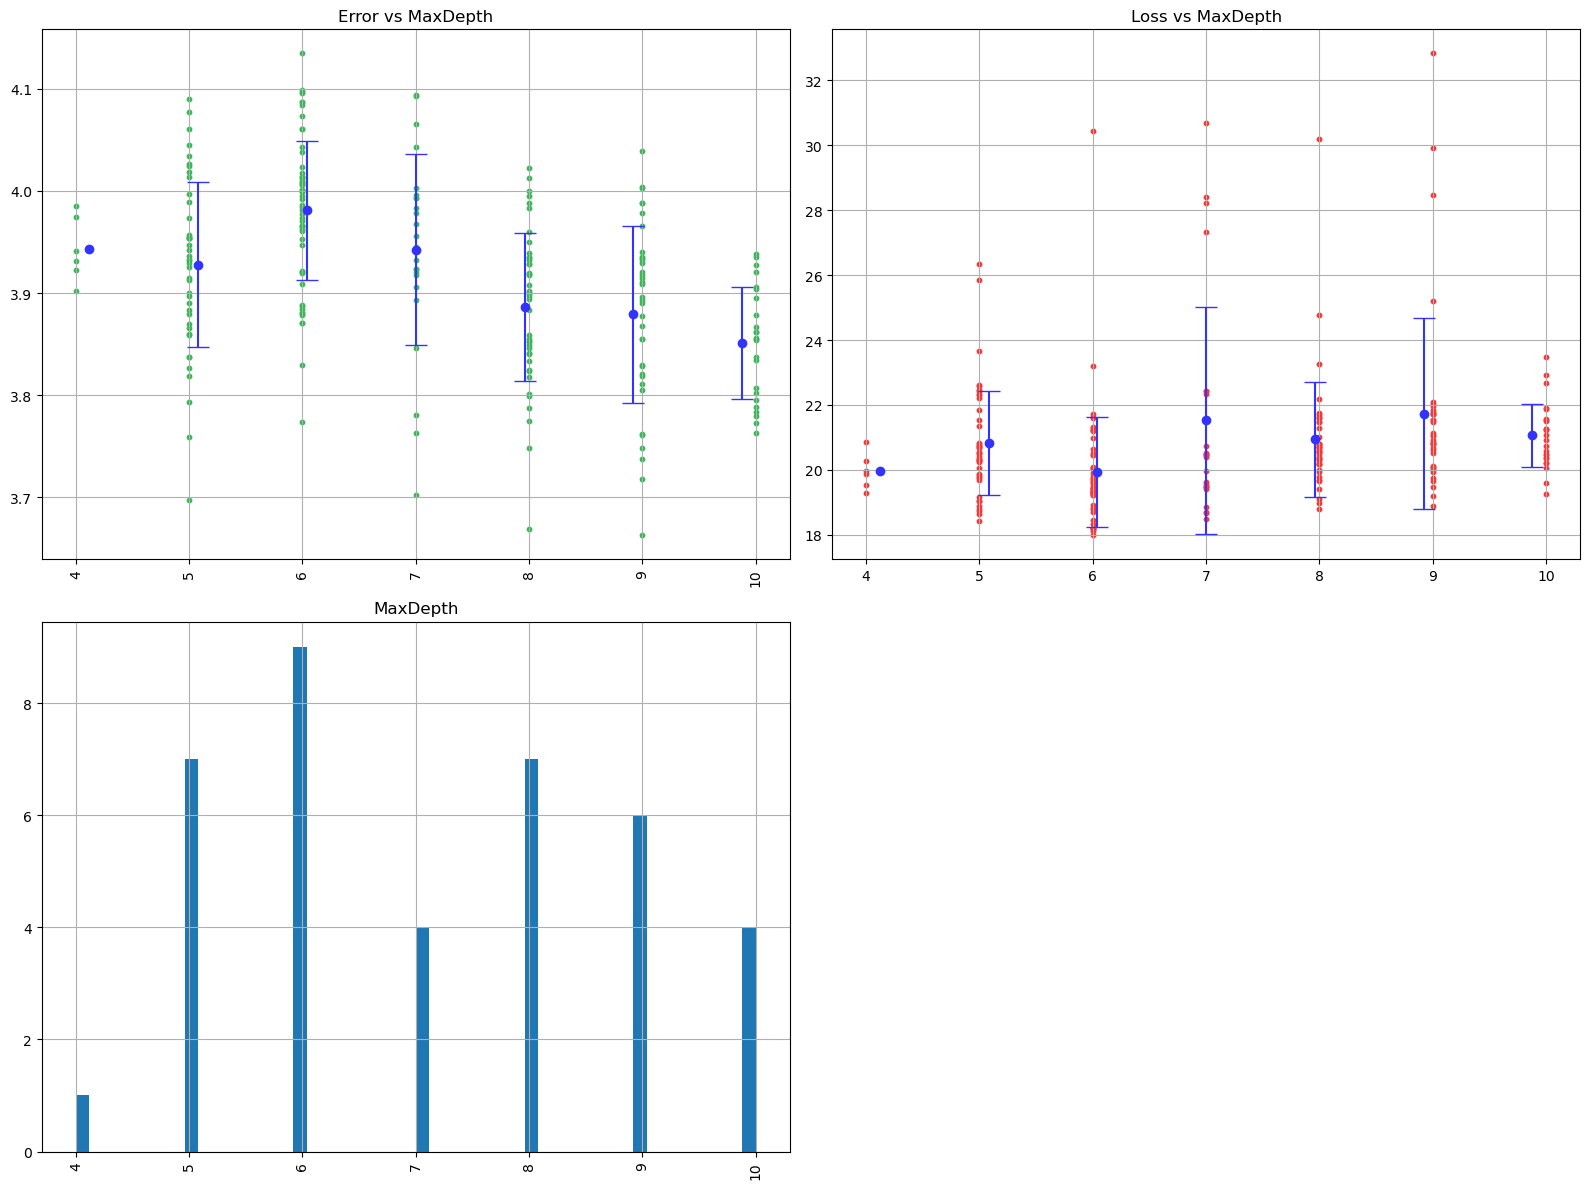

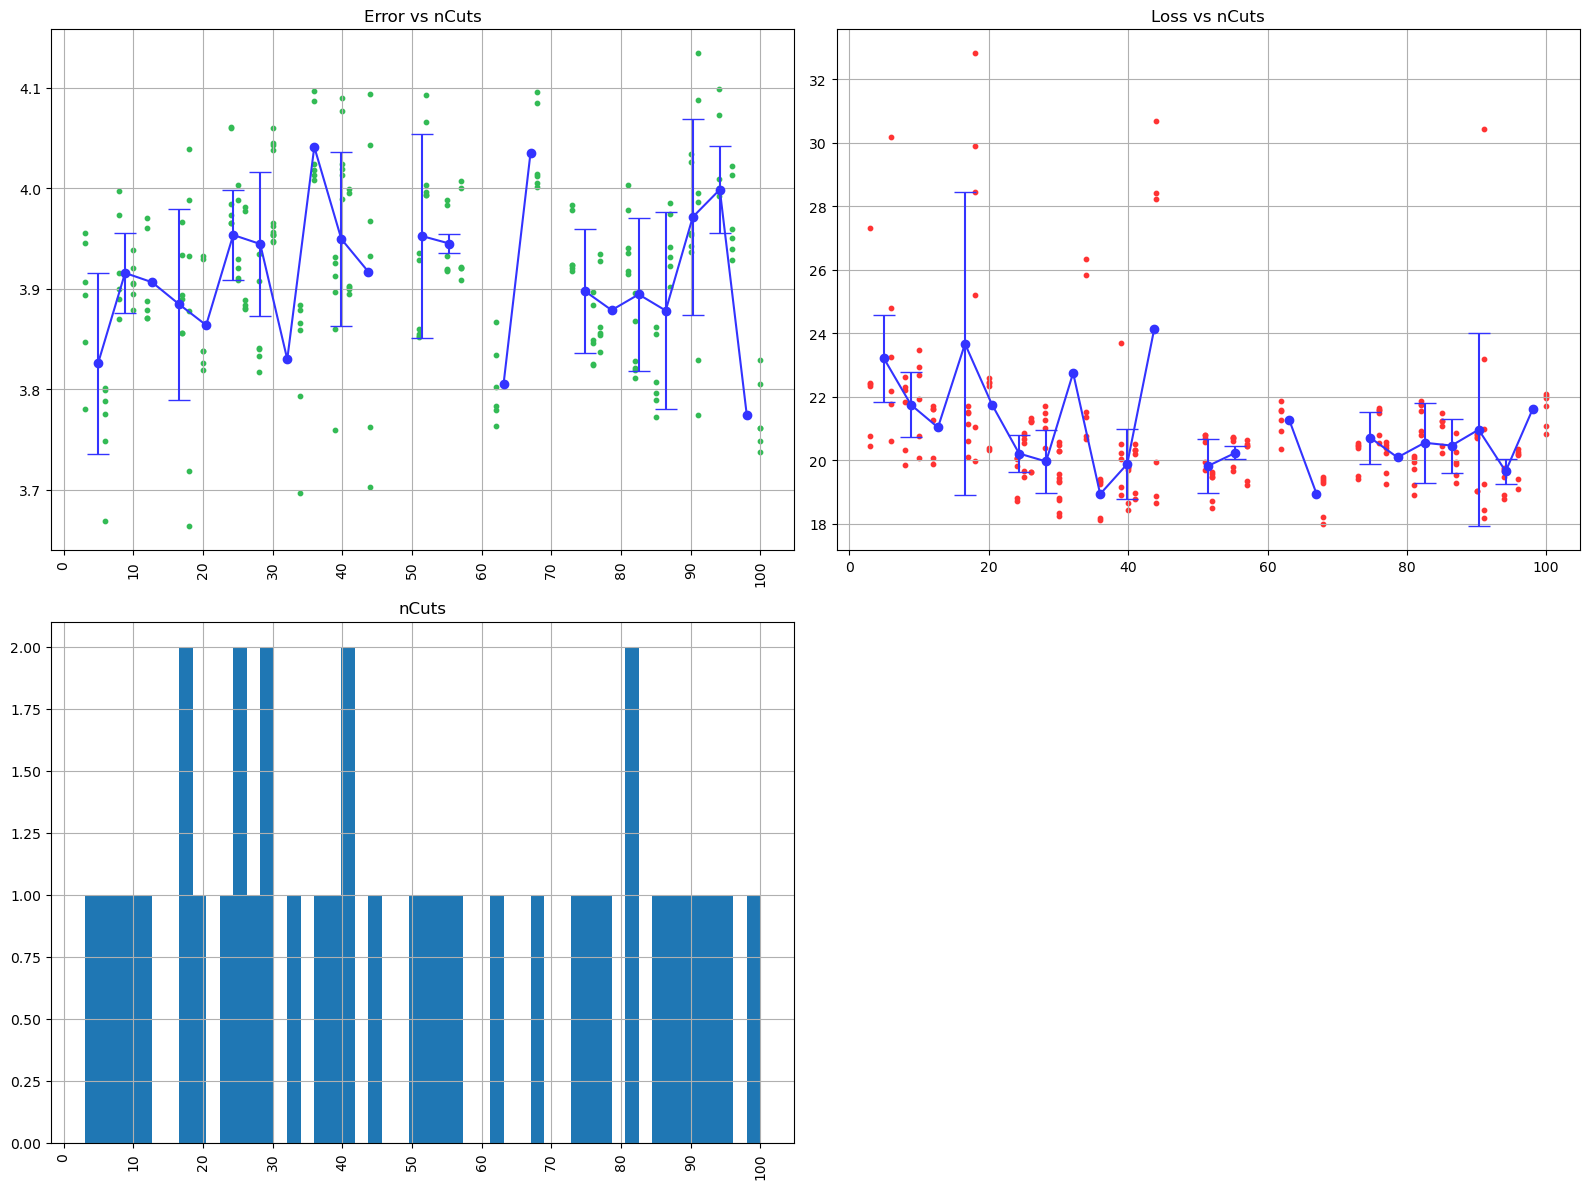

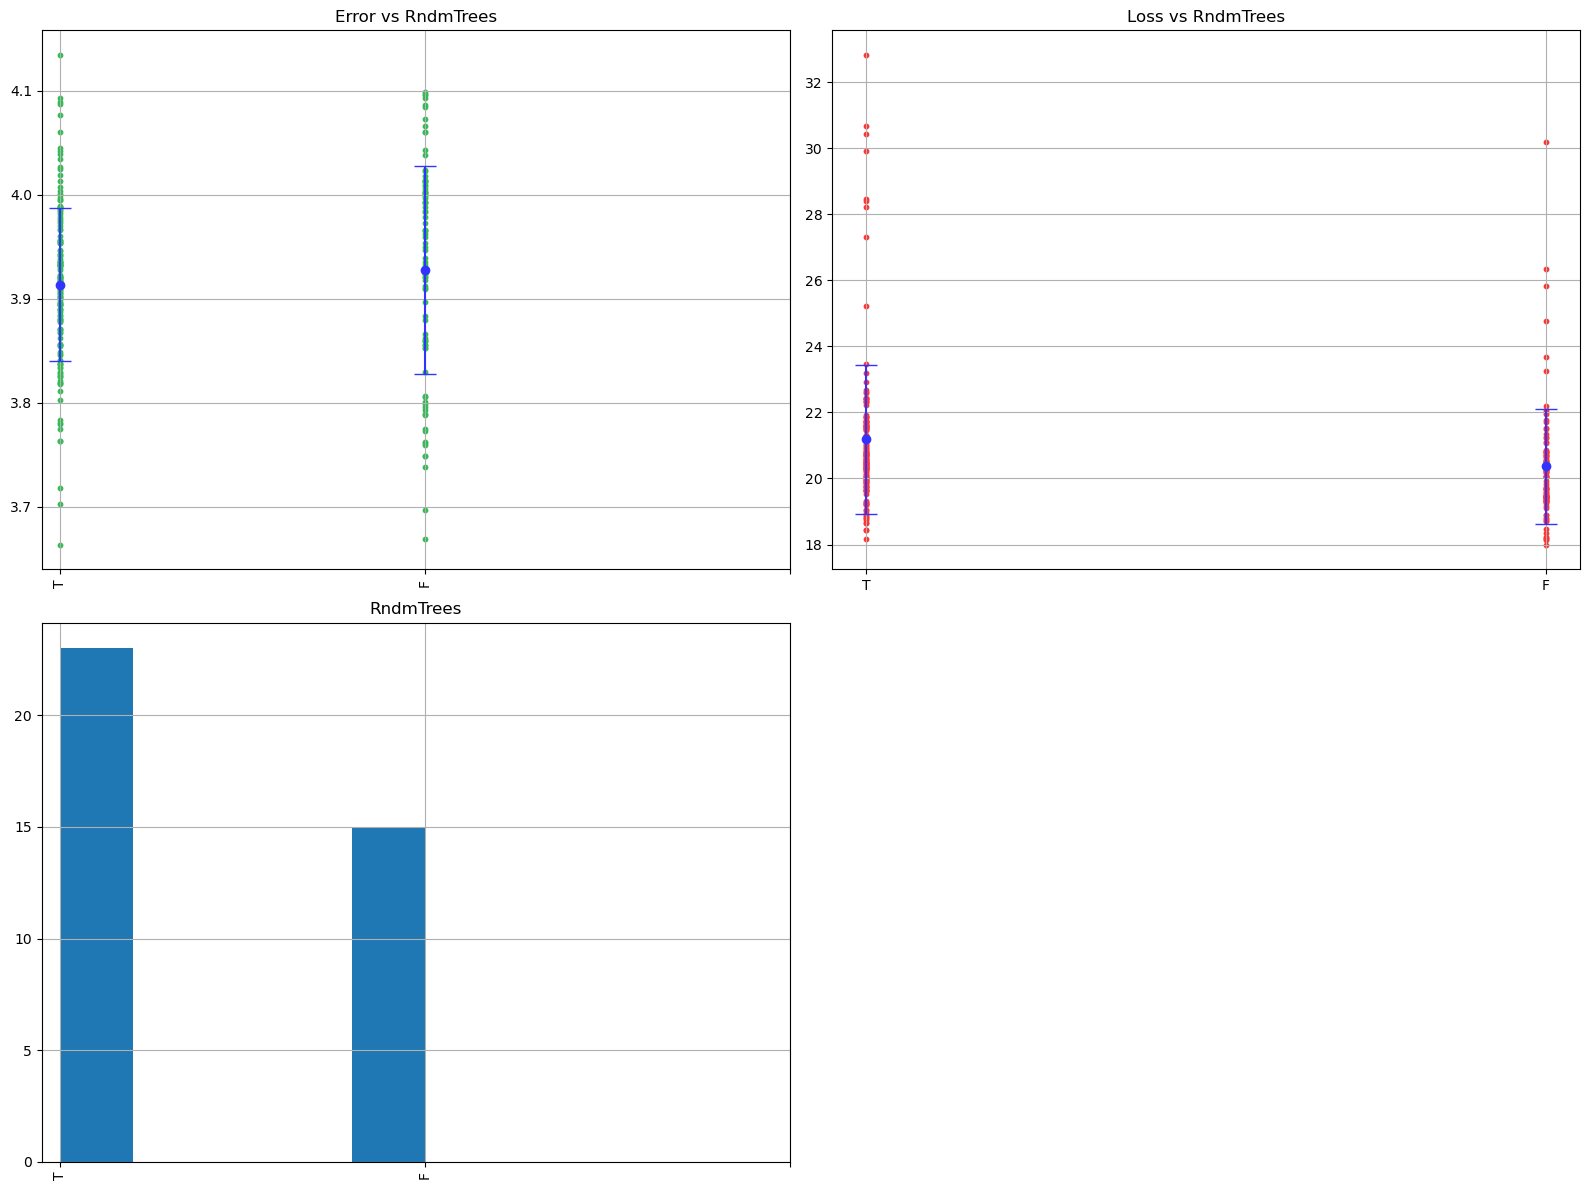

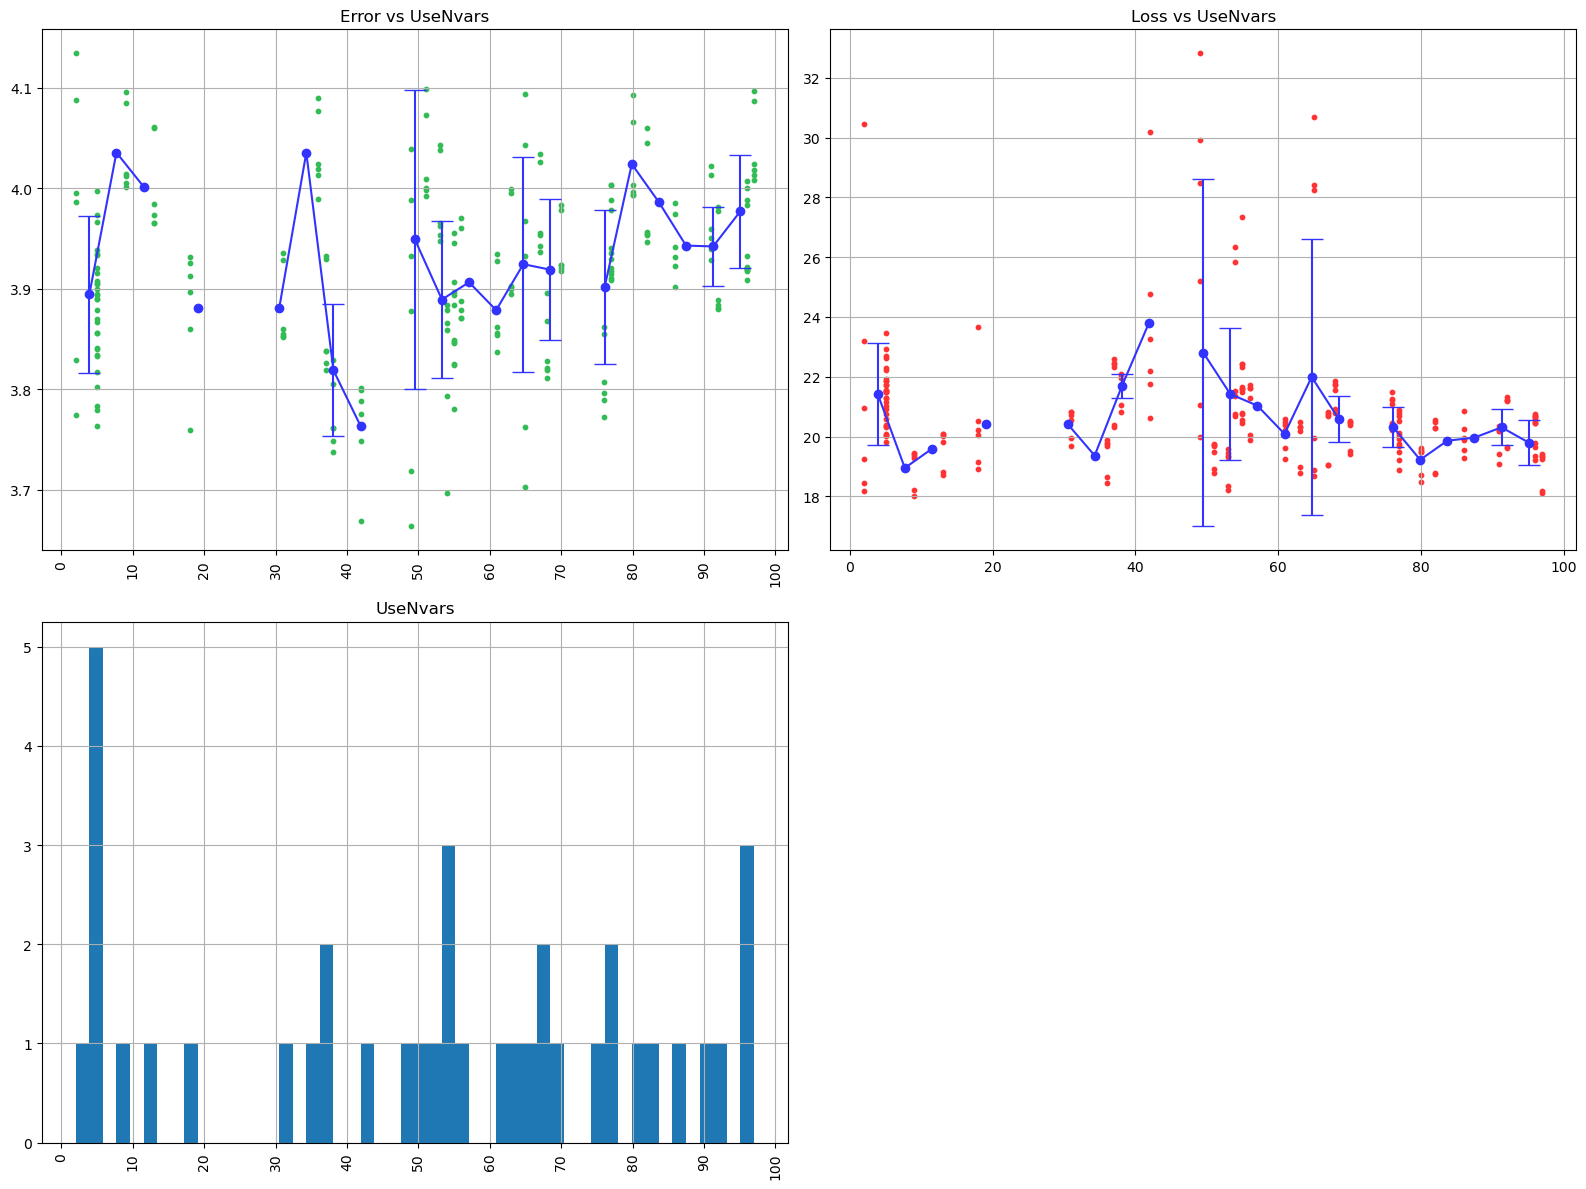

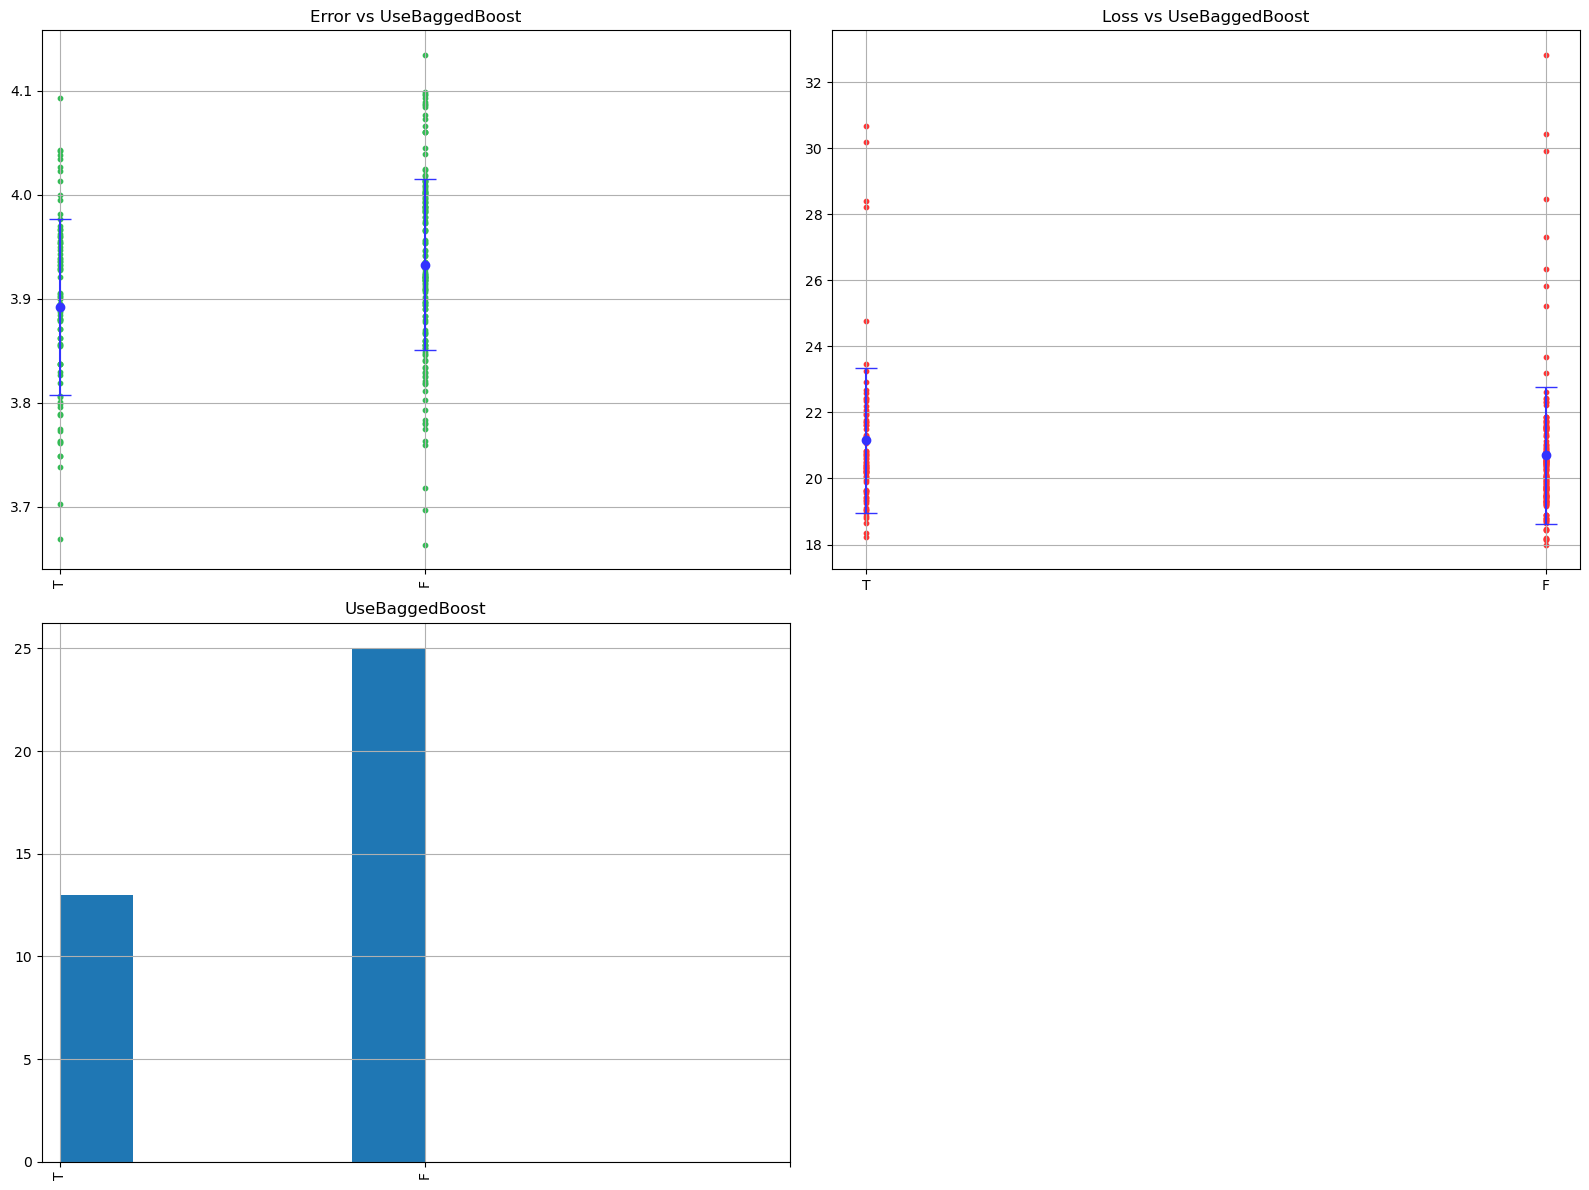

/tmp/ipykernel_43460/2055394149.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bin'+option] = pd.cut(df[option], bins=intervals_option, labels = (intervals_option[:-1]+intervals_option[1:])/2, include_lowest=True)


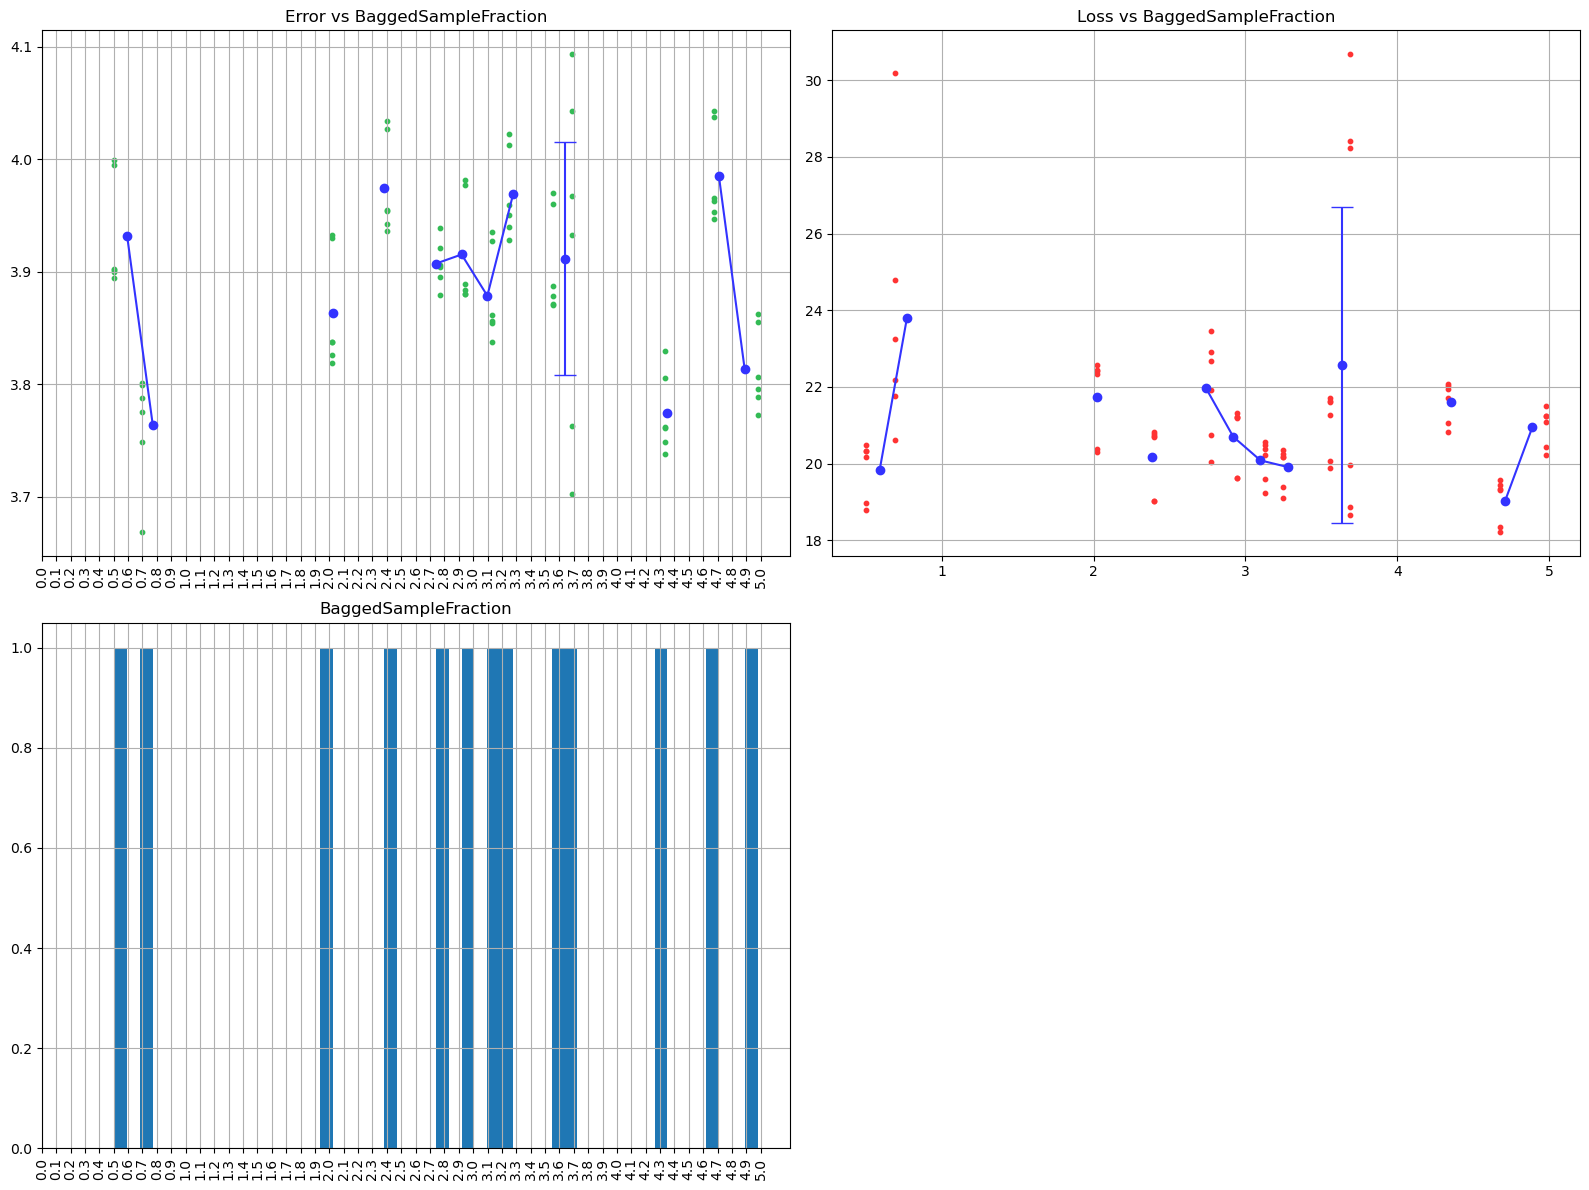

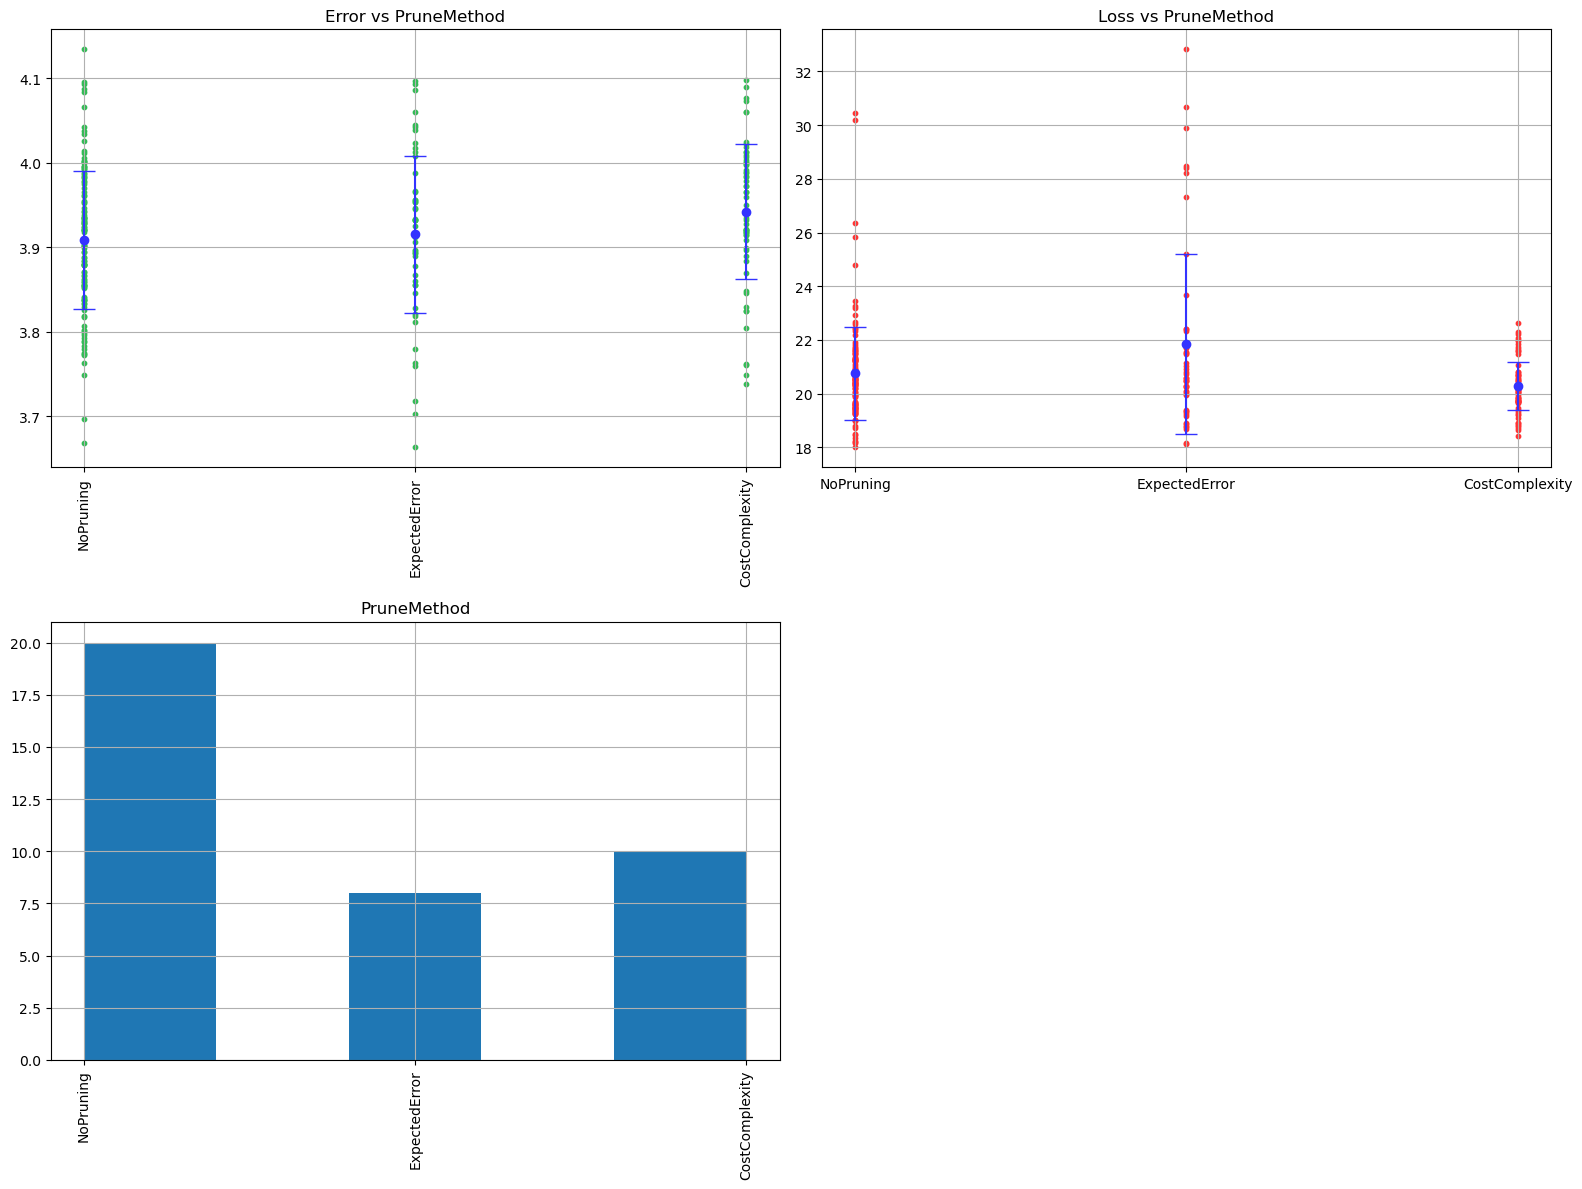

/tmp/ipykernel_43460/2055394149.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bin'+option] = pd.cut(df[option], bins=intervals_option, labels = (intervals_option[:-1]+intervals_option[1:])/2, include_lowest=True)


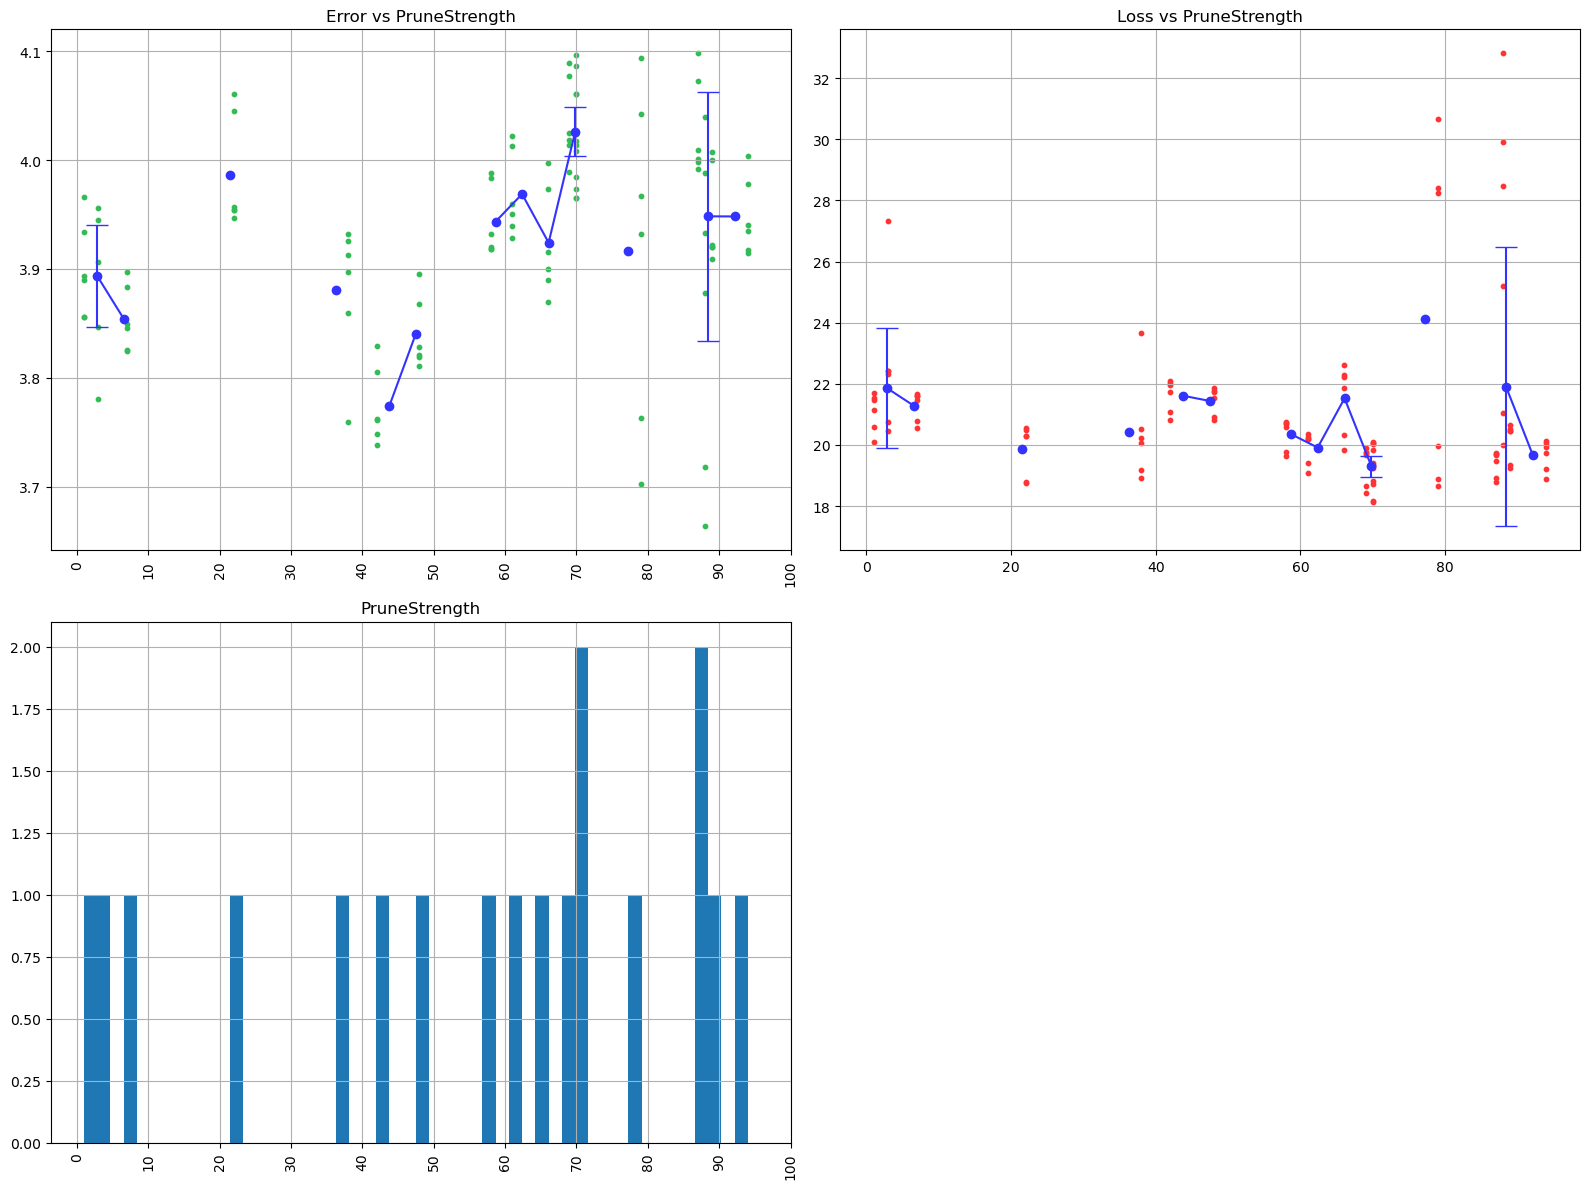

/tmp/ipykernel_43460/2055394149.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Bin'+option] = pd.cut(df[option], bins=intervals_option, labels = (intervals_option[:-1]+intervals_option[1:])/2, include_lowest=True)


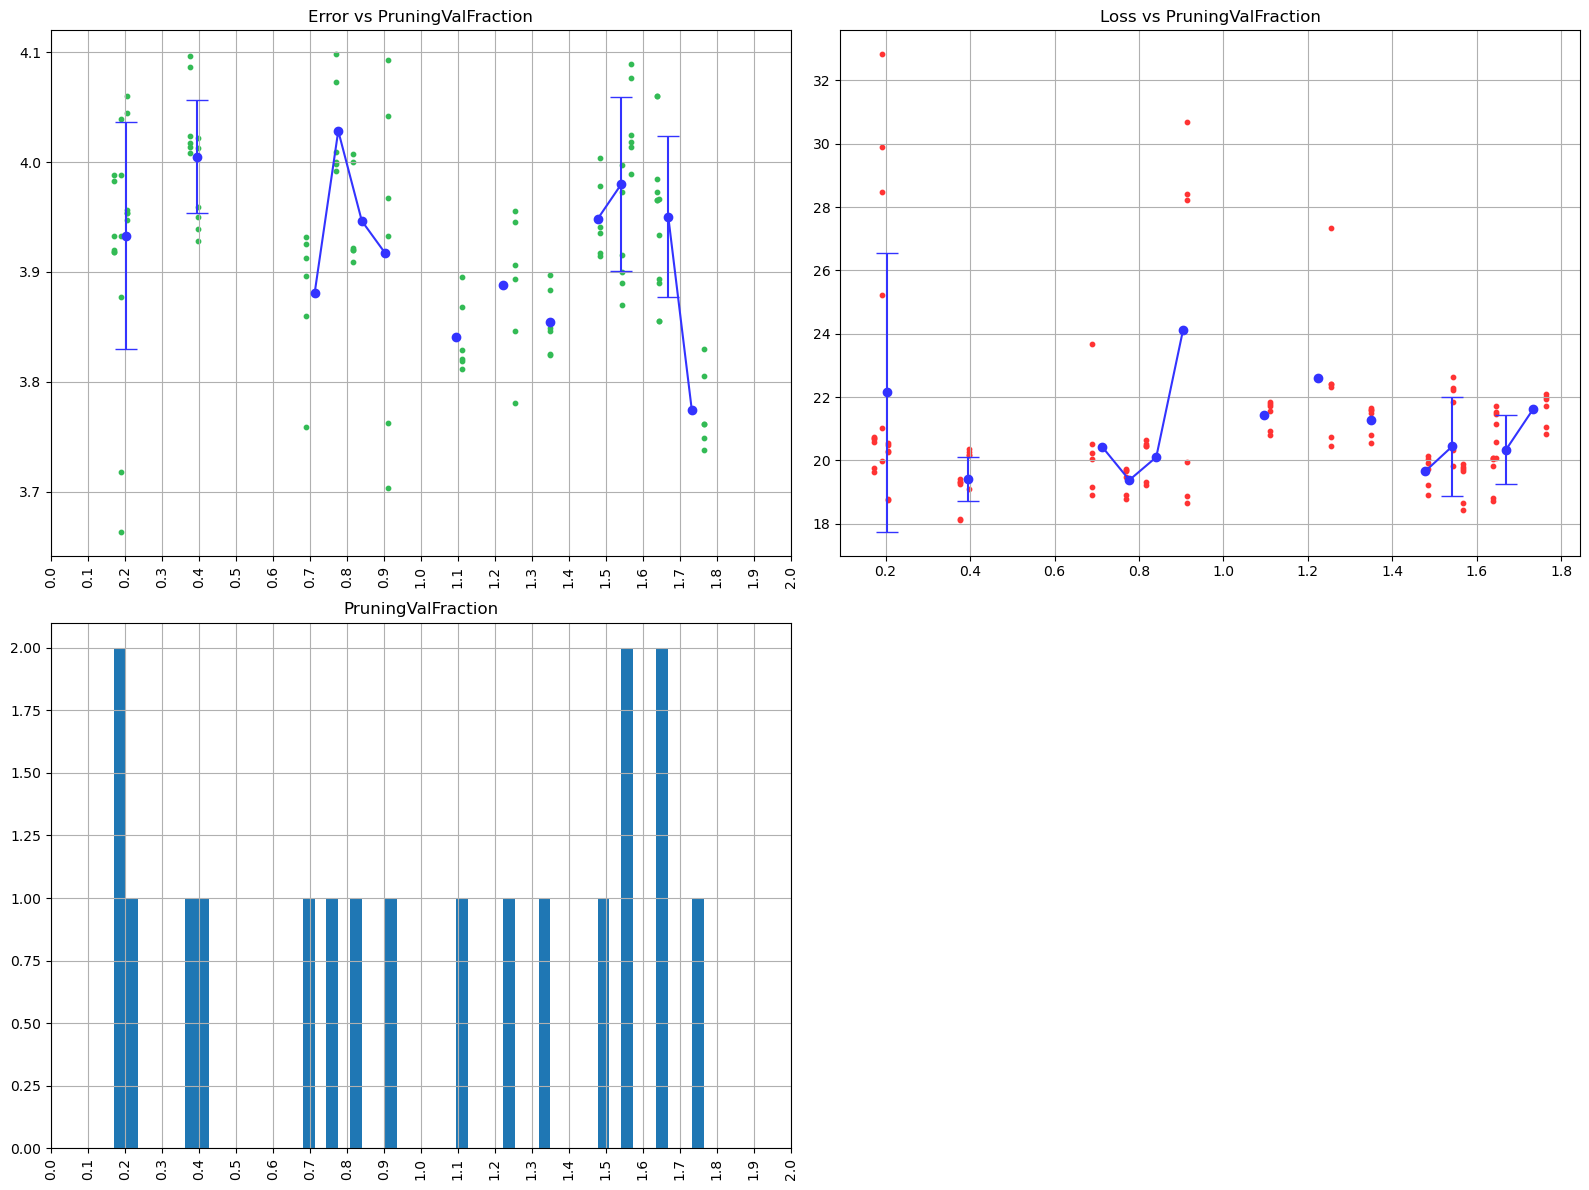

In [87]:
plotOption(pddf, "NTrees", xmin = 0, xmax = 3000, step_size = 100, nbins = 50)
plotOption(pddf, "Shrinkage", xmin = 0, xmax = 1, step_size = 0.1, nbins = 50)
plotOption(pddf, "MaxDepth", xmin = 4, xmax = 10, step_size = 1, nbins = 50)
plotOption(pddf, "nCuts", xmin = 0, xmax = 100, step_size = 10, nbins = 50)
plotOption(pddf, "RndmTrees", xmin = 0, xmax = 2, step_size = 1, nbins = 5)
plotOption(pddf, "UseNvars", xmin = 0, xmax = 100, step_size = 10, nbins = 50)
plotOption(pddf, "UseBaggedBoost", xmin = 0, xmax = 2, step_size = 1, nbins = 5)
plotOption(pddf[pddf["UseBaggedBoost"] == "T"], "BaggedSampleFraction", xmin = 0, xmax = 5, step_size = 0.1, nbins = 50)
plotOption(pddf, "PruneMethod", xmin = 0, xmax = 2, step_size = 1, nbins = 5)
plotOption(pddf[pddf["PruneMethod"] != "NoPruning"], "PruneStrength", xmin = 0, xmax = 100, step_size = 10, nbins = 50)
plotOption(pddf[pddf["PruneMethod"] != "NoPruning"], "PruningValFraction", xmin = 0, xmax = 2, step_size = 0.1, nbins = 50)

7
BDTG_df15_dl3684
BDTG_df15_dl3684_v0_v1_opt587	3.912 (-34.4\%)	18.902	3.094 (-31.5\%)
BDTG_df15_dl3684_v0_v1_opt594	3.837 (-35.6\%)	20.575	3.125 (-30.8\%)
BDTG_df15_dl3684_v0_v1_v4_opt594	3.856 (-35.3\%)	20.488	3.125 (-30.8\%)
BDTG_df15_dl3684_v0_v1_v4_v9_opt587	3.86 (-35.3\%)	20.047	3.055 (-32.4\%)
BDTG_df15_dl3684_v0_v1_v9_opt594	3.854 (-35.4\%)	20.378	3.125 (-30.8\%)
BDTG_df15_dl3684_v1_v4_opt159	3.855 (-35.3\%)	20.448	3.125 (-30.8\%)
RECO                     	5.963 (+0.0\%)	6.438	4.516 (+0.0\%)
7


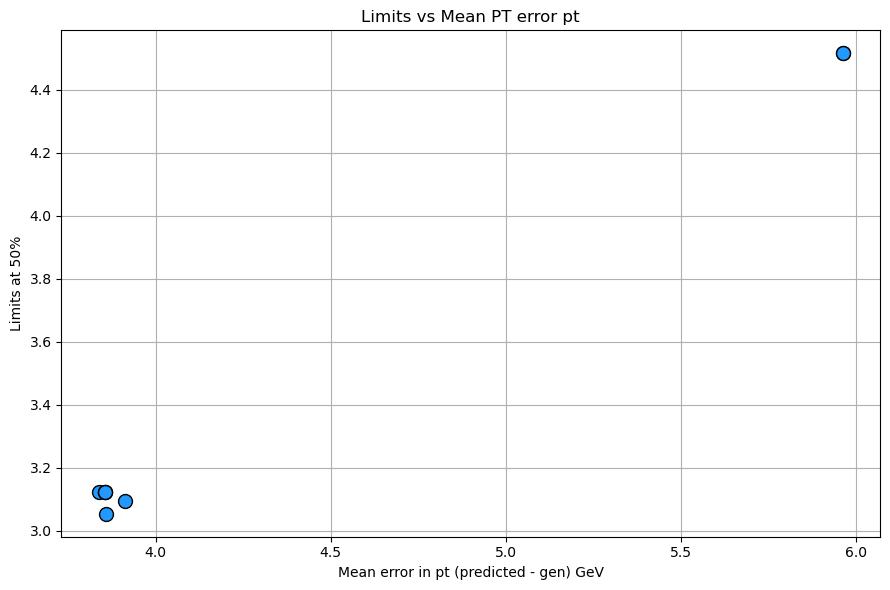

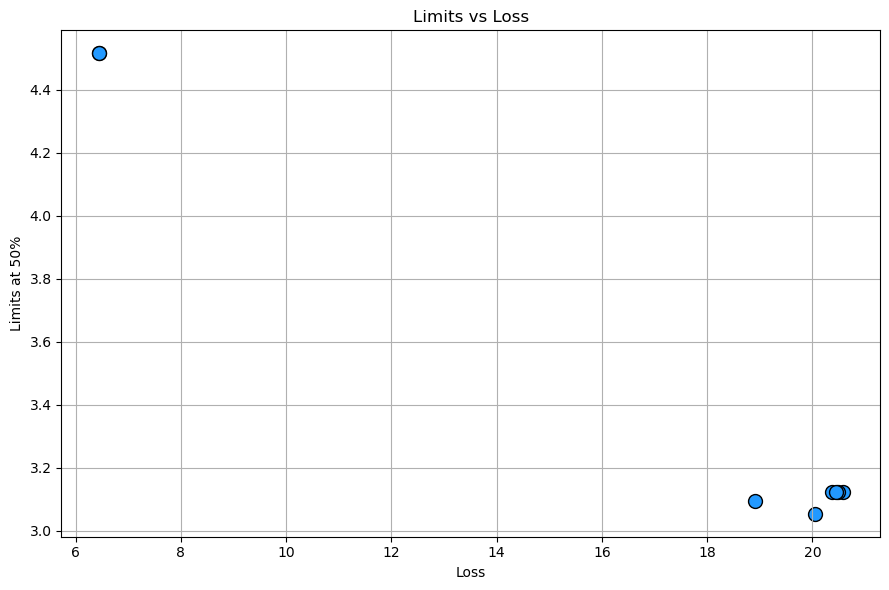

In [97]:
filename = "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/FITS_marti/phi_limits.out"
names, errors, loss, limits = [], [], [], []
with open(filename, 'r') as file:
    for line in file:
        # Split the line into its components using whitespace as the delimiter
        parts = line.strip().split()
        for i, zipped in enumerate(zip(names_filt, errors_filt, losses_filt)):
            if zipped[0] == parts[0]:
                names.append(parts[0])
                errors.append(float(zipped[1]))
                loss.append(float(zipped[2]))
                limits.append(float(parts[1]))

print(len(names))

annotations = []
namesAnn=["BDTG_df15_dl3684_v0_v1",
"BDTG_df15_dl3684_v0_v1_opt587",
"BDTG_df15_dl3684_v0_v1_v9",
"BDTG_df15_dl3684_v0_v1_v4_v9",
"BDTG_df15_dl3684_v1_v4",
"BDTG_df15_dl3684_v1_v4_v9",
        "RECO",]

print("BDTG_df15_dl3684_v0_v1"[:16])
for n, e, l, lim  in zip(names, errors, loss, limits):
    if (lim < 13.5 and e < 4) or n in namesAnn:
        annotations.append([n, e, l, lim])
for a in annotations:
    print("{}\t{} ({:+.1f}\%)\t{}\t{} ({:+.1f}\%)".format(a[0].ljust(25), round(a[1], 3), (a[1]/5.962538036196778-1)*100, round(a[2], 3), round(a[3], 3), (a[3]/4.5156-1)*100))

#FOR Error
plt.figure(figsize=(9, 6))
c = 0
for n, e, l, lims  in zip(names, errors, loss, limits):
    if n == "RECO":
        plt.scatter(e, lims, color="#33bb88", s=100, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_")) == 3:
        plt.scatter(e, lims, color="#ffcc00", s=40, alpha=1.0, edgecolor="#665100")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df15":
        plt.scatter(e, lims, color="#CC0000", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df47":
        plt.scatter(e, lims, color="#00CC00", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df79":
        plt.scatter(e, lims, color="#6666AA", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df111":
        plt.scatter(e, lims, color="#CC00CC", s=40, alpha=1.0, edgecolor="#000000")
        c += 1

for n, e, l, lim in annotations:
    plt.scatter(e, lim, color="#2299ff", s=100, alpha=1.0, edgecolor="#000000")
    #plt.annotate(n, (e, lim), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
print(c)
plt.xlabel('Mean error in pt (predicted - gen) GeV')
plt.ylabel('Limits at 50%')
plt.title('Limits vs Mean PT error pt')
plt.grid()
#plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

#FOR LOSS
plt.figure(figsize=(9, 6))
for n, e, l, lims  in zip(names, errors, loss, limits):
    if n == "RECO":
        plt.scatter(l, lims, color="#33bb88", s=100, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_")) == 3:
        plt.scatter(l, lims, color="#ffcc00", s=40, alpha=1.0, edgecolor="#665100")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df15":
        plt.scatter(l, lims, color="#CC0000", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df47":
        plt.scatter(l, lims, color="#00CC00", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df79":
        plt.scatter(l, lims, color="#6666AA", s=40, alpha=1.0, edgecolor="#000000")
        c += 1
    elif len(n.split("_"))  > 3 and n.split("_")[1] == "df111":
        plt.scatter(l, lims, color="#CC00CC", s=40, alpha=1.0, edgecolor="#000000")
        c += 1

for n, e, l, lim in annotations:
    plt.scatter(l, lim, color="#2299ff", s=100, alpha=1.0, edgecolor="#000000")
    #plt.annotate(n, (l, lim), textcoords="offset points", xytext=(5,-2), ha='left', weight='bold')
plt.xlabel('Loss')
plt.ylabel('Limits at 50%')
plt.title('Limits vs Loss')
plt.grid()
#plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [96]:
models = np.stack((names, errors, loss, limits), axis=0)
sorted_indices = np.argsort(models[3])

# Use these indices to rearrange the rows of the matrix
sorted_matrix = models[:, sorted_indices].T


for element in sorted_matrix[:150]:
    if(float(element[2]) < 35) and element[0][:16] == "BDTG_df15_dl3684_v0_v1"[:16]:
        print("{}\t{}\t{}\t{}".format(element[3], element[0].ljust(25), element[1], element[2]))


3.0547	BDTG_df15_dl3684_v0_v1_v4_v9_opt587	3.859790008713818	20.047025053729076
3.0938	BDTG_df15_dl3684_v0_v1_opt587	3.9124259471765543	18.90235893175838
3.125	BDTG_df15_dl3684_v0_v1_opt594	3.8373012066301033	20.575465860217548
3.125	BDTG_df15_dl3684_v0_v1_v4_opt594	3.856110528665524	20.488441868705614
3.125	BDTG_df15_dl3684_v0_v1_v9_opt594	3.8542675631514465	20.37764681460815
3.125	BDTG_df15_dl3684_v1_v4_opt159	3.855139546980525	20.447670961565635


In [101]:
filename = "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/FITS_marti/doneModels.txt"
doneNames = []
with open(filename, 'r') as file:
    for line in file:
        # Split the line into its components using whitespace as the delimiter
        parts = line.strip().split()
        doneNames.append(parts[0])

doneNames = list(set(doneNames))
newModels = list(set(newModels))
allModels = list(set(newModels + doneNames))
print(len(doneNames))
print(len(newModels))
print(len(allModels))

remainingModels = list(set(newModels).difference(set(doneNames)))
print(len(remainingModels))
for v in remainingModels:
    print(v)






96
43
109
13
BDTG_df15_dl3684_v3_v4_v11
BDTG_df15_dl3684_v3_v4_v9_v10_v11
BDTG_df15_dl3684_v0_v1_v4_v10
BDTG_df15_dl3684_v0_v4_v10_v11
BDTG_df15_dl3684_v3_v4_v10
BDTG_df15_dl3684_v0_v1_v4_v9_v10
BDTG_df15_dl3684_v3_v4_v9_v10
BDTG_df15_dl3684_v0_v1_v9_v10
BDTG_df15_dl3684_v3_v4_v9
BDTG_df15_dl3684_v0_v4_v9_v11
BDTG_df15_dl3684_v1_v4_v9_v10
BDTG_df15_dl3684_v0_v4_v9_v10_v11
BDTG_df15_dl3684_v3_v4_v9_v11
